In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
## Environment
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/models'):
    main_path = p[:-len('/models')]
sys.path[0] = main_path

import os, gc
from termcolor import colored
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from src import (config, fe, features, feature_selection, 
                 preprocess, training)
from src.fe import CreateFeatures

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# DATA PREPARATION
# ===== LOAD DATA ======
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

# Combine train and valid labels
trvl_labels = pd.concat([train_labels, valid_labels], axis = 0)

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

# Define SAM testbed files
sam_files = metadata[(metadata.instrument_type == 'sam_testbed') & (metadata.split == 'train')]['features_path']
sam_files = sam_files.to_dict()

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

# SAM testbed labels
sam_labels = train_labels.drop(train_labels.tail(len(sam_files)).index)
sam_labels = pd.concat([sam_labels, valid_labels], axis=0)
print(f'Labels w/o SAM : {sam_labels.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)
['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']
Labels w/o SAM : (1047, 11)


In [11]:
FTS_NAME = 'fts_mra_tempmz'                 # Name of the file with features
COMPUTE_FTS = False                         # Should the features be recomputed
COMPUTE_FTS_SAM = False                      # Compute SAM test bed
MODEL_ALGO = 'XGB_opt'                      # Name of the classifier
MODEL_NAME = FTS_NAME + '_' + MODEL_ALGO + '_es'    # Name of the model
FTS_SELECT = False

**COMPUTE FEATURES**

- Change the `fe._` method depending on the feature that we wish to calculate

In [12]:
# Check if feature is computed and load it or choose to compute it
check_file = 0
for i in ['_tr', '_trvl', '_vlte']:
    check_file += os.path.exists(os.path.join(config.DATA_DIR_OUT, FTS_NAME +
                                              str(i) + '.csv'))

if (check_file == 3) & (not COMPUTE_FTS):
    print('Reading features ... ')
    X_tr = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_tr.csv'))
    print(X_tr.shape)
    X_trvl = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_trvl.csv'))
    print(X_trvl.shape)
    X_vlte = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_vlte.csv'))
    print(X_vlte.shape)
    
else:
    print('Computing features ... ')
    # ----- TRAIN -----
    fe = CreateFeatures(metadata, train_files, 'tr', FTS_NAME)
    X_tr = fe.fts_mra_tempmz()
    print(colored(f'train => {X_tr.shape}', 'blue'))
    
    # ----- TRAIN & VALID -----
    fe = CreateFeatures(metadata, trva_files, 'trvl', FTS_NAME)
    X_trvl = fe.fts_mra_tempmz()
    print(colored(f'train => {X_trvl.shape}', 'blue'))
    
    # ----- VALID & TEST -----
    fe = CreateFeatures(metadata, all_test_files, 'vlte', FTS_NAME)
    X_vlte = fe.fts_mra_tempmz()
    print(colored(f'train => {X_vlte.shape}', 'blue'))
    
if COMPUTE_FTS_SAM:
    print(f'\nCreating SAM testbed samples ...')
    # Training without SAM testbed
    X_tr_sam = X_tr.drop(X_tr.tail(len(sam_files)).index).copy()
    X_tr_sam = pd.concat([X_tr_sam, X_trvl.iloc[len(train_files):,:]], axis=0)
    print(f'Train shape: {X_tr_sam.shape}')
    # Validation data
    X_vl_sam = X_tr.tail(len(sam_files)).copy()
    print(f'Valid shape: {X_vl_sam.shape}')

Reading features ... 
(766, 1584)
(1059, 1584)
(804, 1584)


## MODELS

**TRAIN**

In [13]:
if FTS_SELECT:
    _, SFM_COLUMNS = feature_selection.fts_select(
        target_labels_list, FTS_NAME, MODEL_NAME, MODEL_ALGO, 'tr',
        X_tr, X_vlte, train_labels, valid_files, valid_labels
    )
else:
    SFM_COLUMNS = None

CV training ....
basalt
[0]	validation_0-logloss:0.62227


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.56369
[2]	validation_0-logloss:0.51288
[3]	validation_0-logloss:0.46944
[4]	validation_0-logloss:0.43185
[5]	validation_0-logloss:0.39795
[6]	validation_0-logloss:0.36757
[7]	validation_0-logloss:0.34241
[8]	validation_0-logloss:0.31777
[9]	validation_0-logloss:0.29879
[10]	validation_0-logloss:0.28101
[11]	validation_0-logloss:0.26574
[12]	validation_0-logloss:0.25202
[13]	validation_0-logloss:0.23633
[14]	validation_0-logloss:0.22312
[15]	validation_0-logloss:0.21165
[16]	validation_0-logloss:0.20046
[17]	validation_0-logloss:0.19201
[18]	validation_0-logloss:0.18373
[19]	validation_0-logloss:0.17797
[20]	validation_0-logloss:0.17228
[21]	validation_0-logloss:0.16794
[22]	validation_0-logloss:0.16018
[23]	validation_0-logloss:0.15714
[24]	validation_0-logloss:0.15027
[25]	validation_0-logloss:0.14739
[26]	validation_0-logloss:0.14287
[27]	validation_0-logloss:0.13622
[28]	validation_0-logloss:0.13085
[29]	validation_0-logloss:0.13029
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.55226
[3]	validation_0-logloss:0.50770
[4]	validation_0-logloss:0.47965
[5]	validation_0-logloss:0.45023
[6]	validation_0-logloss:0.42026
[7]	validation_0-logloss:0.39792
[8]	validation_0-logloss:0.38175
[9]	validation_0-logloss:0.36705
[10]	validation_0-logloss:0.35168
[11]	validation_0-logloss:0.33570
[12]	validation_0-logloss:0.32149
[13]	validation_0-logloss:0.31123
[14]	validation_0-logloss:0.30390
[15]	validation_0-logloss:0.29592
[16]	validation_0-logloss:0.28926
[17]	validation_0-logloss:0.28112
[18]	validation_0-logloss:0.27832
[19]	validation_0-logloss:0.27353
[20]	validation_0-logloss:0.26971
[21]	validation_0-logloss:0.26587
[22]	validation_0-logloss:0.26135
[23]	validation_0-logloss:0.25778
[24]	validation_0-logloss:0.25389
[25]	validation_0-logloss:0.25179
[26]	validation_0-logloss:0.24801
[27]	validation_0-logloss:0.24644
[28]	validation_0-logloss:0.24476
[29]	validation_0-logloss:0.24011
[30]	validation_0-logloss:0.23951
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.51677
[3]	validation_0-logloss:0.47587
[4]	validation_0-logloss:0.43702
[5]	validation_0-logloss:0.40358
[6]	validation_0-logloss:0.37724
[7]	validation_0-logloss:0.35308
[8]	validation_0-logloss:0.33095
[9]	validation_0-logloss:0.31085
[10]	validation_0-logloss:0.29159
[11]	validation_0-logloss:0.27577
[12]	validation_0-logloss:0.25947
[13]	validation_0-logloss:0.24408
[14]	validation_0-logloss:0.23188
[15]	validation_0-logloss:0.22060
[16]	validation_0-logloss:0.21199
[17]	validation_0-logloss:0.20311
[18]	validation_0-logloss:0.19529
[19]	validation_0-logloss:0.18815
[20]	validation_0-logloss:0.18168
[21]	validation_0-logloss:0.17475
[22]	validation_0-logloss:0.16984
[23]	validation_0-logloss:0.16496
[24]	validation_0-logloss:0.15868
[25]	validation_0-logloss:0.15643
[26]	validation_0-logloss:0.15399
[27]	validation_0-logloss:0.15231
[28]	validation_0-logloss:0.14894
[29]	validation_0-logloss:0.14778
[30]	validation_0-logloss:0.14577
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.51222
[3]	validation_0-logloss:0.46870
[4]	validation_0-logloss:0.43135
[5]	validation_0-logloss:0.39565
[6]	validation_0-logloss:0.37163
[7]	validation_0-logloss:0.34559
[8]	validation_0-logloss:0.32404
[9]	validation_0-logloss:0.30661
[10]	validation_0-logloss:0.28765
[11]	validation_0-logloss:0.27093
[12]	validation_0-logloss:0.25727
[13]	validation_0-logloss:0.24529
[14]	validation_0-logloss:0.23514
[15]	validation_0-logloss:0.22259
[16]	validation_0-logloss:0.21315
[17]	validation_0-logloss:0.20454
[18]	validation_0-logloss:0.19625
[19]	validation_0-logloss:0.18798
[20]	validation_0-logloss:0.18022
[21]	validation_0-logloss:0.17381
[22]	validation_0-logloss:0.16743
[23]	validation_0-logloss:0.16384
[24]	validation_0-logloss:0.15886
[25]	validation_0-logloss:0.15708
[26]	validation_0-logloss:0.15332
[27]	validation_0-logloss:0.14986
[28]	validation_0-logloss:0.14666
[29]	validation_0-logloss:0.14237
[30]	validation_0-logloss:0.13963
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.57942
[2]	validation_0-logloss:0.53004
[3]	validation_0-logloss:0.48792
[4]	validation_0-logloss:0.45161
[5]	validation_0-logloss:0.42235
[6]	validation_0-logloss:0.39804
[7]	validation_0-logloss:0.37200
[8]	validation_0-logloss:0.35720
[9]	validation_0-logloss:0.34039
[10]	validation_0-logloss:0.32619
[11]	validation_0-logloss:0.30927
[12]	validation_0-logloss:0.29814
[13]	validation_0-logloss:0.28765
[14]	validation_0-logloss:0.27821
[15]	validation_0-logloss:0.27247
[16]	validation_0-logloss:0.26456
[17]	validation_0-logloss:0.25867
[18]	validation_0-logloss:0.25562
[19]	validation_0-logloss:0.24936
[20]	validation_0-logloss:0.24738
[21]	validation_0-logloss:0.24347
[22]	validation_0-logloss:0.24031
[23]	validation_0-logloss:0.23678
[24]	validation_0-logloss:0.23298
[25]	validation_0-logloss:0.23106
[26]	validation_0-logloss:0.22856
[27]	validation_0-logloss:0.22728
[28]	validation_0-logloss:0.22652
[29]	validation_0-logloss:0.22658
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.52595
[3]	validation_0-logloss:0.48392
[4]	validation_0-logloss:0.44754
[5]	validation_0-logloss:0.41962
[6]	validation_0-logloss:0.39164
[7]	validation_0-logloss:0.36729
[8]	validation_0-logloss:0.34742
[9]	validation_0-logloss:0.32854
[10]	validation_0-logloss:0.31172
[11]	validation_0-logloss:0.29514
[12]	validation_0-logloss:0.28110
[13]	validation_0-logloss:0.27016
[14]	validation_0-logloss:0.25890
[15]	validation_0-logloss:0.24824
[16]	validation_0-logloss:0.23849
[17]	validation_0-logloss:0.23063
[18]	validation_0-logloss:0.22445
[19]	validation_0-logloss:0.21863
[20]	validation_0-logloss:0.21212
[21]	validation_0-logloss:0.20375
[22]	validation_0-logloss:0.19864
[23]	validation_0-logloss:0.19428
[24]	validation_0-logloss:0.18870
[25]	validation_0-logloss:0.18683
[26]	validation_0-logloss:0.18335
[27]	validation_0-logloss:0.17924
[28]	validation_0-logloss:0.17746
[29]	validation_0-logloss:0.17450
[30]	validation_0-logloss:0.17482
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54000
[3]	validation_0-logloss:0.50547
[4]	validation_0-logloss:0.47579
[5]	validation_0-logloss:0.45135
[6]	validation_0-logloss:0.43031
[7]	validation_0-logloss:0.40951
[8]	validation_0-logloss:0.39070
[9]	validation_0-logloss:0.37360
[10]	validation_0-logloss:0.35989
[11]	validation_0-logloss:0.34739
[12]	validation_0-logloss:0.34123
[13]	validation_0-logloss:0.33262
[14]	validation_0-logloss:0.32518
[15]	validation_0-logloss:0.31809
[16]	validation_0-logloss:0.31429
[17]	validation_0-logloss:0.31115
[18]	validation_0-logloss:0.30801
[19]	validation_0-logloss:0.30399
[20]	validation_0-logloss:0.30464
[21]	validation_0-logloss:0.29980
[22]	validation_0-logloss:0.30070
[23]	validation_0-logloss:0.30312
[24]	validation_0-logloss:0.30193
[25]	validation_0-logloss:0.30478
[26]	validation_0-logloss:0.30671
[27]	validation_0-logloss:0.30399
[28]	validation_0-logloss:0.30616
[29]	validation_0-logloss:0.30889
[30]	validation_0-logloss:0.30971
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.57814
[2]	validation_0-logloss:0.53172
[3]	validation_0-logloss:0.48999
[4]	validation_0-logloss:0.45661
[5]	validation_0-logloss:0.43028
[6]	validation_0-logloss:0.40103
[7]	validation_0-logloss:0.37800
[8]	validation_0-logloss:0.35931
[9]	validation_0-logloss:0.33949
[10]	validation_0-logloss:0.31998
[11]	validation_0-logloss:0.30701
[12]	validation_0-logloss:0.29079
[13]	validation_0-logloss:0.27648
[14]	validation_0-logloss:0.26195
[15]	validation_0-logloss:0.24973
[16]	validation_0-logloss:0.24134
[17]	validation_0-logloss:0.23121
[18]	validation_0-logloss:0.22342
[19]	validation_0-logloss:0.21581
[20]	validation_0-logloss:0.20529
[21]	validation_0-logloss:0.20000
[22]	validation_0-logloss:0.19349
[23]	validation_0-logloss:0.18810
[24]	validation_0-logloss:0.18268
[25]	validation_0-logloss:0.17583
[26]	validation_0-logloss:0.17070
[27]	validation_0-logloss:0.16522
[28]	validation_0-logloss:0.16155
[29]	validation_0-logloss:0.15775
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.52941
[3]	validation_0-logloss:0.49094
[4]	validation_0-logloss:0.45742
[5]	validation_0-logloss:0.42482
[6]	validation_0-logloss:0.40347
[7]	validation_0-logloss:0.37972
[8]	validation_0-logloss:0.36057
[9]	validation_0-logloss:0.34235
[10]	validation_0-logloss:0.32412
[11]	validation_0-logloss:0.31081
[12]	validation_0-logloss:0.29660
[13]	validation_0-logloss:0.28504
[14]	validation_0-logloss:0.27320
[15]	validation_0-logloss:0.26510
[16]	validation_0-logloss:0.25888
[17]	validation_0-logloss:0.24936
[18]	validation_0-logloss:0.24208
[19]	validation_0-logloss:0.23235
[20]	validation_0-logloss:0.22603
[21]	validation_0-logloss:0.22175
[22]	validation_0-logloss:0.21522
[23]	validation_0-logloss:0.21219
[24]	validation_0-logloss:0.20789
[25]	validation_0-logloss:0.20593
[26]	validation_0-logloss:0.20303
[27]	validation_0-logloss:0.19933
[28]	validation_0-logloss:0.19657
[29]	validation_0-logloss:0.19429
[30]	validation_0-logloss:0.19251
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54544
[3]	validation_0-logloss:0.51312
[4]	validation_0-logloss:0.48010
[5]	validation_0-logloss:0.45602
[6]	validation_0-logloss:0.43484
[7]	validation_0-logloss:0.41403
[8]	validation_0-logloss:0.40006
[9]	validation_0-logloss:0.38370
[10]	validation_0-logloss:0.37101
[11]	validation_0-logloss:0.36109
[12]	validation_0-logloss:0.34788
[13]	validation_0-logloss:0.33783
[14]	validation_0-logloss:0.33128
[15]	validation_0-logloss:0.32748
[16]	validation_0-logloss:0.32200
[17]	validation_0-logloss:0.31468
[18]	validation_0-logloss:0.30852
[19]	validation_0-logloss:0.29963
[20]	validation_0-logloss:0.29663
[21]	validation_0-logloss:0.29430
[22]	validation_0-logloss:0.29087
[23]	validation_0-logloss:0.28976
[24]	validation_0-logloss:0.28846
[25]	validation_0-logloss:0.28711
[26]	validation_0-logloss:0.28579
[27]	validation_0-logloss:0.28303
[28]	validation_0-logloss:0.28267
[29]	validation_0-logloss:0.28259
[30]	validation_0-logloss:0.28040
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.50452
[3]	validation_0-logloss:0.46288
[4]	validation_0-logloss:0.42567
[5]	validation_0-logloss:0.39332
[6]	validation_0-logloss:0.36583
[7]	validation_0-logloss:0.33945
[8]	validation_0-logloss:0.31724
[9]	validation_0-logloss:0.29509
[10]	validation_0-logloss:0.27701
[11]	validation_0-logloss:0.26023
[12]	validation_0-logloss:0.24618
[13]	validation_0-logloss:0.23352
[14]	validation_0-logloss:0.22224
[15]	validation_0-logloss:0.21287
[16]	validation_0-logloss:0.20316
[17]	validation_0-logloss:0.19505
[18]	validation_0-logloss:0.18842
[19]	validation_0-logloss:0.18137
[20]	validation_0-logloss:0.17346
[21]	validation_0-logloss:0.16750
[22]	validation_0-logloss:0.16295
[23]	validation_0-logloss:0.15661
[24]	validation_0-logloss:0.15246
[25]	validation_0-logloss:0.14752
[26]	validation_0-logloss:0.14228
[27]	validation_0-logloss:0.13972
[28]	validation_0-logloss:0.13629
[29]	validation_0-logloss:0.13264
[30]	validation_0-logloss:0.13073
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.58050
[2]	validation_0-logloss:0.53554
[3]	validation_0-logloss:0.49227
[4]	validation_0-logloss:0.45487
[5]	validation_0-logloss:0.42189
[6]	validation_0-logloss:0.39290
[7]	validation_0-logloss:0.36793
[8]	validation_0-logloss:0.34984
[9]	validation_0-logloss:0.32878
[10]	validation_0-logloss:0.31099
[11]	validation_0-logloss:0.29725
[12]	validation_0-logloss:0.28312
[13]	validation_0-logloss:0.27199
[14]	validation_0-logloss:0.26104
[15]	validation_0-logloss:0.25005
[16]	validation_0-logloss:0.24140
[17]	validation_0-logloss:0.23067
[18]	validation_0-logloss:0.22001
[19]	validation_0-logloss:0.21039
[20]	validation_0-logloss:0.20358
[21]	validation_0-logloss:0.19405
[22]	validation_0-logloss:0.18532
[23]	validation_0-logloss:0.17950
[24]	validation_0-logloss:0.17156
[25]	validation_0-logloss:0.16509
[26]	validation_0-logloss:0.15967
[27]	validation_0-logloss:0.15424
[28]	validation_0-logloss:0.14934
[29]	validation_0-logloss:0.14535
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.52333
[3]	validation_0-logloss:0.48285
[4]	validation_0-logloss:0.44769
[5]	validation_0-logloss:0.41732
[6]	validation_0-logloss:0.39185
[7]	validation_0-logloss:0.36646
[8]	validation_0-logloss:0.34668
[9]	validation_0-logloss:0.32470
[10]	validation_0-logloss:0.30568
[11]	validation_0-logloss:0.28786
[12]	validation_0-logloss:0.27503
[13]	validation_0-logloss:0.26078
[14]	validation_0-logloss:0.24733
[15]	validation_0-logloss:0.23347
[16]	validation_0-logloss:0.21883
[17]	validation_0-logloss:0.20652
[18]	validation_0-logloss:0.19541
[19]	validation_0-logloss:0.18481
[20]	validation_0-logloss:0.17584
[21]	validation_0-logloss:0.16791
[22]	validation_0-logloss:0.16034
[23]	validation_0-logloss:0.15428
[24]	validation_0-logloss:0.14902
[25]	validation_0-logloss:0.14319
[26]	validation_0-logloss:0.13919
[27]	validation_0-logloss:0.13435
[28]	validation_0-logloss:0.13045
[29]	validation_0-logloss:0.12734
[30]	validation_0-logloss:0.12463
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.49810
[3]	validation_0-logloss:0.45331
[4]	validation_0-logloss:0.41491
[5]	validation_0-logloss:0.37851
[6]	validation_0-logloss:0.34813
[7]	validation_0-logloss:0.32338
[8]	validation_0-logloss:0.29742
[9]	validation_0-logloss:0.27620
[10]	validation_0-logloss:0.25743
[11]	validation_0-logloss:0.23997
[12]	validation_0-logloss:0.22240
[13]	validation_0-logloss:0.20755
[14]	validation_0-logloss:0.19483
[15]	validation_0-logloss:0.18201
[16]	validation_0-logloss:0.17047
[17]	validation_0-logloss:0.16019
[18]	validation_0-logloss:0.15140
[19]	validation_0-logloss:0.14341
[20]	validation_0-logloss:0.13592
[21]	validation_0-logloss:0.12973
[22]	validation_0-logloss:0.12329
[23]	validation_0-logloss:0.11717
[24]	validation_0-logloss:0.10976
[25]	validation_0-logloss:0.10330
[26]	validation_0-logloss:0.09881
[27]	validation_0-logloss:0.09332
[28]	validation_0-logloss:0.08971
[29]	validation_0-logloss:0.08598
[30]	validation_0-logloss:0.08286
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.51781
[3]	validation_0-logloss:0.47635
[4]	validation_0-logloss:0.43983
[5]	validation_0-logloss:0.40855
[6]	validation_0-logloss:0.38096
[7]	validation_0-logloss:0.35813
[8]	validation_0-logloss:0.33951
[9]	validation_0-logloss:0.32075
[10]	validation_0-logloss:0.30141
[11]	validation_0-logloss:0.28394
[12]	validation_0-logloss:0.27069
[13]	validation_0-logloss:0.25515
[14]	validation_0-logloss:0.24489
[15]	validation_0-logloss:0.23415
[16]	validation_0-logloss:0.22714
[17]	validation_0-logloss:0.21900
[18]	validation_0-logloss:0.20840
[19]	validation_0-logloss:0.20016
[20]	validation_0-logloss:0.19194
[21]	validation_0-logloss:0.18544
[22]	validation_0-logloss:0.18156
[23]	validation_0-logloss:0.17635
[24]	validation_0-logloss:0.16909
[25]	validation_0-logloss:0.16215
[26]	validation_0-logloss:0.15737
[27]	validation_0-logloss:0.15363
[28]	validation_0-logloss:0.15019
[29]	validation_0-logloss:0.14712
[30]	validation_0-logloss:0.14297
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.56754
[2]	validation_0-logloss:0.52341
[3]	validation_0-logloss:0.48482
[4]	validation_0-logloss:0.44940
[5]	validation_0-logloss:0.41751
[6]	validation_0-logloss:0.39116
[7]	validation_0-logloss:0.36624
[8]	validation_0-logloss:0.34586
[9]	validation_0-logloss:0.32740
[10]	validation_0-logloss:0.30545
[11]	validation_0-logloss:0.28782
[12]	validation_0-logloss:0.26921
[13]	validation_0-logloss:0.25371
[14]	validation_0-logloss:0.24118
[15]	validation_0-logloss:0.23009
[16]	validation_0-logloss:0.22014
[17]	validation_0-logloss:0.21129
[18]	validation_0-logloss:0.20238
[19]	validation_0-logloss:0.19141
[20]	validation_0-logloss:0.18436
[21]	validation_0-logloss:0.17613
[22]	validation_0-logloss:0.16701
[23]	validation_0-logloss:0.15845
[24]	validation_0-logloss:0.15246
[25]	validation_0-logloss:0.14665
[26]	validation_0-logloss:0.13943
[27]	validation_0-logloss:0.13443
[28]	validation_0-logloss:0.13068
[29]	validation_0-logloss:0.12877
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.52850
[3]	validation_0-logloss:0.48829
[4]	validation_0-logloss:0.45893
[5]	validation_0-logloss:0.42880
[6]	validation_0-logloss:0.40689
[7]	validation_0-logloss:0.38401
[8]	validation_0-logloss:0.36874
[9]	validation_0-logloss:0.35046
[10]	validation_0-logloss:0.33802
[11]	validation_0-logloss:0.32514
[12]	validation_0-logloss:0.31342
[13]	validation_0-logloss:0.30661
[14]	validation_0-logloss:0.29964
[15]	validation_0-logloss:0.29393
[16]	validation_0-logloss:0.28596
[17]	validation_0-logloss:0.28053
[18]	validation_0-logloss:0.27753
[19]	validation_0-logloss:0.27114
[20]	validation_0-logloss:0.26863
[21]	validation_0-logloss:0.26604
[22]	validation_0-logloss:0.26357
[23]	validation_0-logloss:0.26062
[24]	validation_0-logloss:0.25997
[25]	validation_0-logloss:0.25931
[26]	validation_0-logloss:0.25723
[27]	validation_0-logloss:0.25534
[28]	validation_0-logloss:0.25258
[29]	validation_0-logloss:0.25075
[30]	validation_0-logloss:0.25073
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.50168
[3]	validation_0-logloss:0.45576
[4]	validation_0-logloss:0.41550
[5]	validation_0-logloss:0.37984
[6]	validation_0-logloss:0.35070
[7]	validation_0-logloss:0.32342
[8]	validation_0-logloss:0.29835
[9]	validation_0-logloss:0.27633
[10]	validation_0-logloss:0.25615
[11]	validation_0-logloss:0.23939
[12]	validation_0-logloss:0.22339
[13]	validation_0-logloss:0.20908
[14]	validation_0-logloss:0.19612
[15]	validation_0-logloss:0.18437
[16]	validation_0-logloss:0.17327
[17]	validation_0-logloss:0.16470
[18]	validation_0-logloss:0.15630
[19]	validation_0-logloss:0.14924
[20]	validation_0-logloss:0.14253
[21]	validation_0-logloss:0.13485
[22]	validation_0-logloss:0.12853
[23]	validation_0-logloss:0.12166
[24]	validation_0-logloss:0.11599
[25]	validation_0-logloss:0.11077
[26]	validation_0-logloss:0.10474
[27]	validation_0-logloss:0.09941
[28]	validation_0-logloss:0.09570
[29]	validation_0-logloss:0.09230
[30]	validation_0-logloss:0.08818
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53495
[3]	validation_0-logloss:0.49485
[4]	validation_0-logloss:0.46405
[5]	validation_0-logloss:0.43772
[6]	validation_0-logloss:0.41283
[7]	validation_0-logloss:0.38940
[8]	validation_0-logloss:0.36762
[9]	validation_0-logloss:0.35207
[10]	validation_0-logloss:0.33742
[11]	validation_0-logloss:0.32046
[12]	validation_0-logloss:0.31151
[13]	validation_0-logloss:0.29855
[14]	validation_0-logloss:0.28754
[15]	validation_0-logloss:0.27822
[16]	validation_0-logloss:0.26999
[17]	validation_0-logloss:0.26214
[18]	validation_0-logloss:0.25622
[19]	validation_0-logloss:0.25183
[20]	validation_0-logloss:0.24605
[21]	validation_0-logloss:0.23813
[22]	validation_0-logloss:0.22864
[23]	validation_0-logloss:0.22201
[24]	validation_0-logloss:0.21589
[25]	validation_0-logloss:0.21073
[26]	validation_0-logloss:0.20690
[27]	validation_0-logloss:0.20312
[28]	validation_0-logloss:0.19723
[29]	validation_0-logloss:0.19067
[30]	validation_0-logloss:0.18740
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53370
[3]	validation_0-logloss:0.49583
[4]	validation_0-logloss:0.46425
[5]	validation_0-logloss:0.43746
[6]	validation_0-logloss:0.41575
[7]	validation_0-logloss:0.39714
[8]	validation_0-logloss:0.38017
[9]	validation_0-logloss:0.36579
[10]	validation_0-logloss:0.35511
[11]	validation_0-logloss:0.34518
[12]	validation_0-logloss:0.33063
[13]	validation_0-logloss:0.31953
[14]	validation_0-logloss:0.31128
[15]	validation_0-logloss:0.30007
[16]	validation_0-logloss:0.28985
[17]	validation_0-logloss:0.28285
[18]	validation_0-logloss:0.27707
[19]	validation_0-logloss:0.27040
[20]	validation_0-logloss:0.26740
[21]	validation_0-logloss:0.26456
[22]	validation_0-logloss:0.26098
[23]	validation_0-logloss:0.25655
[24]	validation_0-logloss:0.25189
[25]	validation_0-logloss:0.24819
[26]	validation_0-logloss:0.24766
[27]	validation_0-logloss:0.24714
[28]	validation_0-logloss:0.24701
[29]	validation_0-logloss:0.24099
[30]	validation_0-logloss:0.23714
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53732
[3]	validation_0-logloss:0.49916
[4]	validation_0-logloss:0.47029
[5]	validation_0-logloss:0.44280
[6]	validation_0-logloss:0.42263
[7]	validation_0-logloss:0.39968
[8]	validation_0-logloss:0.37690
[9]	validation_0-logloss:0.36035
[10]	validation_0-logloss:0.34109
[11]	validation_0-logloss:0.32561
[12]	validation_0-logloss:0.31619
[13]	validation_0-logloss:0.30447
[14]	validation_0-logloss:0.29741
[15]	validation_0-logloss:0.28965
[16]	validation_0-logloss:0.28027
[17]	validation_0-logloss:0.27303
[18]	validation_0-logloss:0.26569
[19]	validation_0-logloss:0.26117
[20]	validation_0-logloss:0.25706
[21]	validation_0-logloss:0.25159
[22]	validation_0-logloss:0.24769
[23]	validation_0-logloss:0.24300
[24]	validation_0-logloss:0.24068
[25]	validation_0-logloss:0.23622
[26]	validation_0-logloss:0.23570
[27]	validation_0-logloss:0.23057
[28]	validation_0-logloss:0.22888
[29]	validation_0-logloss:0.23008
[30]	validation_0-logloss:0.22771
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.58105
[2]	validation_0-logloss:0.53522
[3]	validation_0-logloss:0.49315
[4]	validation_0-logloss:0.45492
[5]	validation_0-logloss:0.42380
[6]	validation_0-logloss:0.39880
[7]	validation_0-logloss:0.37629
[8]	validation_0-logloss:0.35649
[9]	validation_0-logloss:0.33536
[10]	validation_0-logloss:0.31997
[11]	validation_0-logloss:0.30323
[12]	validation_0-logloss:0.28697
[13]	validation_0-logloss:0.27183
[14]	validation_0-logloss:0.26095
[15]	validation_0-logloss:0.25231
[16]	validation_0-logloss:0.24155
[17]	validation_0-logloss:0.23603
[18]	validation_0-logloss:0.22641
[19]	validation_0-logloss:0.22334
[20]	validation_0-logloss:0.21829
[21]	validation_0-logloss:0.21572
[22]	validation_0-logloss:0.21118
[23]	validation_0-logloss:0.20824
[24]	validation_0-logloss:0.20495
[25]	validation_0-logloss:0.20454
[26]	validation_0-logloss:0.19824
[27]	validation_0-logloss:0.19450
[28]	validation_0-logloss:0.19253
[29]	validation_0-logloss:0.18768
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54513
[3]	validation_0-logloss:0.50754
[4]	validation_0-logloss:0.47375
[5]	validation_0-logloss:0.44478
[6]	validation_0-logloss:0.41931
[7]	validation_0-logloss:0.39817
[8]	validation_0-logloss:0.37959
[9]	validation_0-logloss:0.36310
[10]	validation_0-logloss:0.35000
[11]	validation_0-logloss:0.33903
[12]	validation_0-logloss:0.32796
[13]	validation_0-logloss:0.31902
[14]	validation_0-logloss:0.30783
[15]	validation_0-logloss:0.30142
[16]	validation_0-logloss:0.29509
[17]	validation_0-logloss:0.29098
[18]	validation_0-logloss:0.28401
[19]	validation_0-logloss:0.27978
[20]	validation_0-logloss:0.27229
[21]	validation_0-logloss:0.26697
[22]	validation_0-logloss:0.26531
[23]	validation_0-logloss:0.26252
[24]	validation_0-logloss:0.26032
[25]	validation_0-logloss:0.25886
[26]	validation_0-logloss:0.25623
[27]	validation_0-logloss:0.25414
[28]	validation_0-logloss:0.25405
[29]	validation_0-logloss:0.25055
[30]	validation_0-logloss:0.24717
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54445
[3]	validation_0-logloss:0.51608
[4]	validation_0-logloss:0.49410
[5]	validation_0-logloss:0.46765
[6]	validation_0-logloss:0.44479
[7]	validation_0-logloss:0.42187
[8]	validation_0-logloss:0.40321
[9]	validation_0-logloss:0.38936
[10]	validation_0-logloss:0.37178
[11]	validation_0-logloss:0.36045
[12]	validation_0-logloss:0.35144
[13]	validation_0-logloss:0.33960
[14]	validation_0-logloss:0.32661
[15]	validation_0-logloss:0.32008
[16]	validation_0-logloss:0.31243
[17]	validation_0-logloss:0.30352
[18]	validation_0-logloss:0.29529
[19]	validation_0-logloss:0.29123
[20]	validation_0-logloss:0.28449
[21]	validation_0-logloss:0.27942
[22]	validation_0-logloss:0.27538
[23]	validation_0-logloss:0.26944
[24]	validation_0-logloss:0.26538
[25]	validation_0-logloss:0.26333
[26]	validation_0-logloss:0.26237
[27]	validation_0-logloss:0.26075
[28]	validation_0-logloss:0.26004
[29]	validation_0-logloss:0.25900
[30]	validation_0-logloss:0.25857
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54719
[3]	validation_0-logloss:0.51831
[4]	validation_0-logloss:0.48406
[5]	validation_0-logloss:0.46523
[6]	validation_0-logloss:0.44462
[7]	validation_0-logloss:0.42403
[8]	validation_0-logloss:0.41285
[9]	validation_0-logloss:0.39970
[10]	validation_0-logloss:0.38357
[11]	validation_0-logloss:0.37547
[12]	validation_0-logloss:0.36848
[13]	validation_0-logloss:0.35823
[14]	validation_0-logloss:0.34438
[15]	validation_0-logloss:0.33295
[16]	validation_0-logloss:0.32876
[17]	validation_0-logloss:0.31885
[18]	validation_0-logloss:0.31350
[19]	validation_0-logloss:0.30858
[20]	validation_0-logloss:0.30676
[21]	validation_0-logloss:0.30190
[22]	validation_0-logloss:0.29636
[23]	validation_0-logloss:0.29399
[24]	validation_0-logloss:0.28968
[25]	validation_0-logloss:0.29052
[26]	validation_0-logloss:0.29262
[27]	validation_0-logloss:0.29150
[28]	validation_0-logloss:0.28695
[29]	validation_0-logloss:0.28739
[30]	validation_0-logloss:0.28762
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.52775
[3]	validation_0-logloss:0.48866
[4]	validation_0-logloss:0.45431
[5]	validation_0-logloss:0.42875
[6]	validation_0-logloss:0.40486
[7]	validation_0-logloss:0.38401
[8]	validation_0-logloss:0.36580
[9]	validation_0-logloss:0.34862
[10]	validation_0-logloss:0.33337
[11]	validation_0-logloss:0.31959
[12]	validation_0-logloss:0.30660
[13]	validation_0-logloss:0.29488
[14]	validation_0-logloss:0.28601
[15]	validation_0-logloss:0.27659
[16]	validation_0-logloss:0.27172
[17]	validation_0-logloss:0.26465
[18]	validation_0-logloss:0.25983
[19]	validation_0-logloss:0.25593
[20]	validation_0-logloss:0.24994
[21]	validation_0-logloss:0.24583
[22]	validation_0-logloss:0.24189
[23]	validation_0-logloss:0.23696
[24]	validation_0-logloss:0.23384
[25]	validation_0-logloss:0.23156
[26]	validation_0-logloss:0.23011
[27]	validation_0-logloss:0.22681
[28]	validation_0-logloss:0.22610
[29]	validation_0-logloss:0.22499
[30]	validation_0-logloss:0.22188
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54452
[3]	validation_0-logloss:0.50488
[4]	validation_0-logloss:0.47311
[5]	validation_0-logloss:0.43720
[6]	validation_0-logloss:0.40729
[7]	validation_0-logloss:0.38015
[8]	validation_0-logloss:0.35421
[9]	validation_0-logloss:0.33538
[10]	validation_0-logloss:0.31890
[11]	validation_0-logloss:0.30382
[12]	validation_0-logloss:0.28851
[13]	validation_0-logloss:0.27522
[14]	validation_0-logloss:0.26354
[15]	validation_0-logloss:0.25186
[16]	validation_0-logloss:0.24548
[17]	validation_0-logloss:0.23733
[18]	validation_0-logloss:0.23022
[19]	validation_0-logloss:0.22124
[20]	validation_0-logloss:0.21470
[21]	validation_0-logloss:0.20836
[22]	validation_0-logloss:0.20227
[23]	validation_0-logloss:0.19812
[24]	validation_0-logloss:0.19234
[25]	validation_0-logloss:0.18883
[26]	validation_0-logloss:0.18789
[27]	validation_0-logloss:0.18235
[28]	validation_0-logloss:0.17614
[29]	validation_0-logloss:0.17349
[30]	validation_0-logloss:0.17050
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.52784
[3]	validation_0-logloss:0.48925
[4]	validation_0-logloss:0.45558
[5]	validation_0-logloss:0.42820
[6]	validation_0-logloss:0.40171
[7]	validation_0-logloss:0.37770
[8]	validation_0-logloss:0.35785
[9]	validation_0-logloss:0.33801
[10]	validation_0-logloss:0.32129
[11]	validation_0-logloss:0.30117
[12]	validation_0-logloss:0.28281
[13]	validation_0-logloss:0.27132
[14]	validation_0-logloss:0.26054
[15]	validation_0-logloss:0.25135
[16]	validation_0-logloss:0.23990
[17]	validation_0-logloss:0.23191
[18]	validation_0-logloss:0.22512
[19]	validation_0-logloss:0.21694
[20]	validation_0-logloss:0.21229
[21]	validation_0-logloss:0.20724
[22]	validation_0-logloss:0.20422
[23]	validation_0-logloss:0.19760
[24]	validation_0-logloss:0.19522
[25]	validation_0-logloss:0.19233
[26]	validation_0-logloss:0.18874
[27]	validation_0-logloss:0.18614
[28]	validation_0-logloss:0.18374
[29]	validation_0-logloss:0.18234
[30]	validation_0-logloss:0.18063
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53898
[3]	validation_0-logloss:0.50110
[4]	validation_0-logloss:0.46536
[5]	validation_0-logloss:0.43790
[6]	validation_0-logloss:0.40998
[7]	validation_0-logloss:0.38847
[8]	validation_0-logloss:0.37149
[9]	validation_0-logloss:0.35120
[10]	validation_0-logloss:0.33516
[11]	validation_0-logloss:0.31631
[12]	validation_0-logloss:0.30082
[13]	validation_0-logloss:0.28750
[14]	validation_0-logloss:0.27320
[15]	validation_0-logloss:0.26211
[16]	validation_0-logloss:0.25345
[17]	validation_0-logloss:0.24296
[18]	validation_0-logloss:0.23131
[19]	validation_0-logloss:0.22193
[20]	validation_0-logloss:0.21242
[21]	validation_0-logloss:0.20231
[22]	validation_0-logloss:0.19580
[23]	validation_0-logloss:0.18695
[24]	validation_0-logloss:0.18221
[25]	validation_0-logloss:0.17570
[26]	validation_0-logloss:0.16995
[27]	validation_0-logloss:0.16494
[28]	validation_0-logloss:0.15986
[29]	validation_0-logloss:0.15576
[30]	validation_0-logloss:0.15299
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54460
[3]	validation_0-logloss:0.50775
[4]	validation_0-logloss:0.47379
[5]	validation_0-logloss:0.44421
[6]	validation_0-logloss:0.42309
[7]	validation_0-logloss:0.40335
[8]	validation_0-logloss:0.38591
[9]	validation_0-logloss:0.37252
[10]	validation_0-logloss:0.36346
[11]	validation_0-logloss:0.35321
[12]	validation_0-logloss:0.33657
[13]	validation_0-logloss:0.31862
[14]	validation_0-logloss:0.30896
[15]	validation_0-logloss:0.30492
[16]	validation_0-logloss:0.29469
[17]	validation_0-logloss:0.29087
[18]	validation_0-logloss:0.27885
[19]	validation_0-logloss:0.27365
[20]	validation_0-logloss:0.26613
[21]	validation_0-logloss:0.26135
[22]	validation_0-logloss:0.25305
[23]	validation_0-logloss:0.25223
[24]	validation_0-logloss:0.24474
[25]	validation_0-logloss:0.24328
[26]	validation_0-logloss:0.24148
[27]	validation_0-logloss:0.23610
[28]	validation_0-logloss:0.23366
[29]	validation_0-logloss:0.22826
[30]	validation_0-logloss:0.22554
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.55492
[3]	validation_0-logloss:0.52282
[4]	validation_0-logloss:0.49059
[5]	validation_0-logloss:0.47129
[6]	validation_0-logloss:0.44547
[7]	validation_0-logloss:0.42273
[8]	validation_0-logloss:0.40929
[9]	validation_0-logloss:0.39137
[10]	validation_0-logloss:0.37505
[11]	validation_0-logloss:0.36291
[12]	validation_0-logloss:0.35151
[13]	validation_0-logloss:0.34446
[14]	validation_0-logloss:0.33648
[15]	validation_0-logloss:0.32774
[16]	validation_0-logloss:0.32095
[17]	validation_0-logloss:0.31889
[18]	validation_0-logloss:0.31458
[19]	validation_0-logloss:0.30752
[20]	validation_0-logloss:0.30507
[21]	validation_0-logloss:0.30332
[22]	validation_0-logloss:0.30131
[23]	validation_0-logloss:0.30123
[24]	validation_0-logloss:0.29921
[25]	validation_0-logloss:0.29832
[26]	validation_0-logloss:0.29581
[27]	validation_0-logloss:0.29701
[28]	validation_0-logloss:0.29831
[29]	validation_0-logloss:0.29673
[30]	validation_0-logloss:0.29772
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.58718
[2]	validation_0-logloss:0.54644
[3]	validation_0-logloss:0.51780
[4]	validation_0-logloss:0.49284
[5]	validation_0-logloss:0.47139
[6]	validation_0-logloss:0.44649
[7]	validation_0-logloss:0.43050
[8]	validation_0-logloss:0.41594
[9]	validation_0-logloss:0.40243
[10]	validation_0-logloss:0.38872
[11]	validation_0-logloss:0.37491
[12]	validation_0-logloss:0.36042
[13]	validation_0-logloss:0.35317
[14]	validation_0-logloss:0.34167
[15]	validation_0-logloss:0.33435
[16]	validation_0-logloss:0.32404
[17]	validation_0-logloss:0.31650
[18]	validation_0-logloss:0.30670
[19]	validation_0-logloss:0.29929
[20]	validation_0-logloss:0.29185
[21]	validation_0-logloss:0.28569
[22]	validation_0-logloss:0.28446
[23]	validation_0-logloss:0.27886
[24]	validation_0-logloss:0.27400
[25]	validation_0-logloss:0.26639
[26]	validation_0-logloss:0.26000
[27]	validation_0-logloss:0.25660
[28]	validation_0-logloss:0.25260
[29]	validation_0-logloss:0.24729
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.56483
[3]	validation_0-logloss:0.53187
[4]	validation_0-logloss:0.50690
[5]	validation_0-logloss:0.48489
[6]	validation_0-logloss:0.46738
[7]	validation_0-logloss:0.44691
[8]	validation_0-logloss:0.43194
[9]	validation_0-logloss:0.41744
[10]	validation_0-logloss:0.40909
[11]	validation_0-logloss:0.39747
[12]	validation_0-logloss:0.39018
[13]	validation_0-logloss:0.37987
[14]	validation_0-logloss:0.37178
[15]	validation_0-logloss:0.36291
[16]	validation_0-logloss:0.35519
[17]	validation_0-logloss:0.34608
[18]	validation_0-logloss:0.33770
[19]	validation_0-logloss:0.33327
[20]	validation_0-logloss:0.32448
[21]	validation_0-logloss:0.31676
[22]	validation_0-logloss:0.31437
[23]	validation_0-logloss:0.30947
[24]	validation_0-logloss:0.30339
[25]	validation_0-logloss:0.30141
[26]	validation_0-logloss:0.29436
[27]	validation_0-logloss:0.29316
[28]	validation_0-logloss:0.29072
[29]	validation_0-logloss:0.28624
[30]	validation_0-logloss:0.28438
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.56446
[3]	validation_0-logloss:0.53034
[4]	validation_0-logloss:0.49838
[5]	validation_0-logloss:0.46696
[6]	validation_0-logloss:0.44675
[7]	validation_0-logloss:0.42898
[8]	validation_0-logloss:0.40813
[9]	validation_0-logloss:0.39529
[10]	validation_0-logloss:0.38076
[11]	validation_0-logloss:0.36724
[12]	validation_0-logloss:0.35100
[13]	validation_0-logloss:0.34453
[14]	validation_0-logloss:0.33729
[15]	validation_0-logloss:0.32760
[16]	validation_0-logloss:0.31677
[17]	validation_0-logloss:0.30843
[18]	validation_0-logloss:0.30308
[19]	validation_0-logloss:0.29972
[20]	validation_0-logloss:0.29365
[21]	validation_0-logloss:0.28832
[22]	validation_0-logloss:0.27636
[23]	validation_0-logloss:0.26988
[24]	validation_0-logloss:0.26691
[25]	validation_0-logloss:0.26229
[26]	validation_0-logloss:0.25853
[27]	validation_0-logloss:0.25368
[28]	validation_0-logloss:0.25137
[29]	validation_0-logloss:0.24783
[30]	validation_0-logloss:0.24138
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.56568
[3]	validation_0-logloss:0.53540
[4]	validation_0-logloss:0.50468
[5]	validation_0-logloss:0.48159
[6]	validation_0-logloss:0.46117
[7]	validation_0-logloss:0.44131
[8]	validation_0-logloss:0.42322
[9]	validation_0-logloss:0.40639
[10]	validation_0-logloss:0.38911
[11]	validation_0-logloss:0.37509
[12]	validation_0-logloss:0.36119
[13]	validation_0-logloss:0.35767
[14]	validation_0-logloss:0.34790
[15]	validation_0-logloss:0.34198
[16]	validation_0-logloss:0.33333
[17]	validation_0-logloss:0.32542
[18]	validation_0-logloss:0.31907
[19]	validation_0-logloss:0.31282
[20]	validation_0-logloss:0.30789
[21]	validation_0-logloss:0.30219
[22]	validation_0-logloss:0.29867
[23]	validation_0-logloss:0.29784
[24]	validation_0-logloss:0.29738
[25]	validation_0-logloss:0.29442
[26]	validation_0-logloss:0.29311
[27]	validation_0-logloss:0.29322
[28]	validation_0-logloss:0.29175
[29]	validation_0-logloss:0.28829
[30]	validation_0-logloss:0.28452
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.58011
[2]	validation_0-logloss:0.53851
[3]	validation_0-logloss:0.50134
[4]	validation_0-logloss:0.46838
[5]	validation_0-logloss:0.44200
[6]	validation_0-logloss:0.41958
[7]	validation_0-logloss:0.39854
[8]	validation_0-logloss:0.38270
[9]	validation_0-logloss:0.36548
[10]	validation_0-logloss:0.35068
[11]	validation_0-logloss:0.33361
[12]	validation_0-logloss:0.31953
[13]	validation_0-logloss:0.30876
[14]	validation_0-logloss:0.29763
[15]	validation_0-logloss:0.29216
[16]	validation_0-logloss:0.28504
[17]	validation_0-logloss:0.27505
[18]	validation_0-logloss:0.26917
[19]	validation_0-logloss:0.26408
[20]	validation_0-logloss:0.25923
[21]	validation_0-logloss:0.25510
[22]	validation_0-logloss:0.24869
[23]	validation_0-logloss:0.24096
[24]	validation_0-logloss:0.23650
[25]	validation_0-logloss:0.22849
[26]	validation_0-logloss:0.22462
[27]	validation_0-logloss:0.22183
[28]	validation_0-logloss:0.22039
[29]	validation_0-logloss:0.21527
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.58490
[3]	validation_0-logloss:0.56092
[4]	validation_0-logloss:0.54151
[5]	validation_0-logloss:0.51969
[6]	validation_0-logloss:0.50397
[7]	validation_0-logloss:0.48725
[8]	validation_0-logloss:0.47867
[9]	validation_0-logloss:0.46461
[10]	validation_0-logloss:0.45359
[11]	validation_0-logloss:0.44501
[12]	validation_0-logloss:0.43306
[13]	validation_0-logloss:0.42874
[14]	validation_0-logloss:0.41733
[15]	validation_0-logloss:0.41407
[16]	validation_0-logloss:0.41098
[17]	validation_0-logloss:0.40748
[18]	validation_0-logloss:0.40498
[19]	validation_0-logloss:0.40201
[20]	validation_0-logloss:0.40181
[21]	validation_0-logloss:0.39543
[22]	validation_0-logloss:0.38988
[23]	validation_0-logloss:0.38191
[24]	validation_0-logloss:0.37866
[25]	validation_0-logloss:0.37937
[26]	validation_0-logloss:0.37338
[27]	validation_0-logloss:0.37490
[28]	validation_0-logloss:0.37361
[29]	validation_0-logloss:0.37356
[30]	validation_0-logloss:0.37441
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.56440
[3]	validation_0-logloss:0.53075
[4]	validation_0-logloss:0.50128
[5]	validation_0-logloss:0.47566
[6]	validation_0-logloss:0.45139
[7]	validation_0-logloss:0.43269
[8]	validation_0-logloss:0.41139
[9]	validation_0-logloss:0.39804
[10]	validation_0-logloss:0.38431
[11]	validation_0-logloss:0.37063
[12]	validation_0-logloss:0.35818
[13]	validation_0-logloss:0.34278
[14]	validation_0-logloss:0.33018
[15]	validation_0-logloss:0.31719
[16]	validation_0-logloss:0.30778
[17]	validation_0-logloss:0.30058
[18]	validation_0-logloss:0.29385
[19]	validation_0-logloss:0.28416
[20]	validation_0-logloss:0.27773
[21]	validation_0-logloss:0.27124
[22]	validation_0-logloss:0.26789
[23]	validation_0-logloss:0.25921
[24]	validation_0-logloss:0.25426
[25]	validation_0-logloss:0.25123
[26]	validation_0-logloss:0.24742
[27]	validation_0-logloss:0.24451
[28]	validation_0-logloss:0.24227
[29]	validation_0-logloss:0.24083
[30]	validation_0-logloss:0.23577
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.56427
[3]	validation_0-logloss:0.53465
[4]	validation_0-logloss:0.51035
[5]	validation_0-logloss:0.48360
[6]	validation_0-logloss:0.45802
[7]	validation_0-logloss:0.44119
[8]	validation_0-logloss:0.42133
[9]	validation_0-logloss:0.41109
[10]	validation_0-logloss:0.39762
[11]	validation_0-logloss:0.38735
[12]	validation_0-logloss:0.37326
[13]	validation_0-logloss:0.36312
[14]	validation_0-logloss:0.35147
[15]	validation_0-logloss:0.34595
[16]	validation_0-logloss:0.34105
[17]	validation_0-logloss:0.33164
[18]	validation_0-logloss:0.32466
[19]	validation_0-logloss:0.32105
[20]	validation_0-logloss:0.31606
[21]	validation_0-logloss:0.30842
[22]	validation_0-logloss:0.30219
[23]	validation_0-logloss:0.29591
[24]	validation_0-logloss:0.29229
[25]	validation_0-logloss:0.28990
[26]	validation_0-logloss:0.28547
[27]	validation_0-logloss:0.28171
[28]	validation_0-logloss:0.27740
[29]	validation_0-logloss:0.27493
[30]	validation_0-logloss:0.27408
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.56913
[3]	validation_0-logloss:0.53591
[4]	validation_0-logloss:0.50587
[5]	validation_0-logloss:0.48383
[6]	validation_0-logloss:0.45763
[7]	validation_0-logloss:0.44069
[8]	validation_0-logloss:0.41956
[9]	validation_0-logloss:0.40470
[10]	validation_0-logloss:0.38817
[11]	validation_0-logloss:0.37775
[12]	validation_0-logloss:0.36770
[13]	validation_0-logloss:0.35392
[14]	validation_0-logloss:0.34181
[15]	validation_0-logloss:0.33261
[16]	validation_0-logloss:0.32537
[17]	validation_0-logloss:0.31669
[18]	validation_0-logloss:0.30366
[19]	validation_0-logloss:0.29890
[20]	validation_0-logloss:0.29000
[21]	validation_0-logloss:0.28430
[22]	validation_0-logloss:0.27541
[23]	validation_0-logloss:0.26718
[24]	validation_0-logloss:0.26176
[25]	validation_0-logloss:0.25513
[26]	validation_0-logloss:0.24886
[27]	validation_0-logloss:0.24413
[28]	validation_0-logloss:0.23687
[29]	validation_0-logloss:0.23119
[30]	validation_0-logloss:0.22860
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.44379
[4]	validation_0-logloss:0.40246
[5]	validation_0-logloss:0.36657
[6]	validation_0-logloss:0.33525
[7]	validation_0-logloss:0.30780
[8]	validation_0-logloss:0.28434
[9]	validation_0-logloss:0.26298
[10]	validation_0-logloss:0.24411
[11]	validation_0-logloss:0.22812
[12]	validation_0-logloss:0.21323
[13]	validation_0-logloss:0.20001
[14]	validation_0-logloss:0.18827
[15]	validation_0-logloss:0.17784
[16]	validation_0-logloss:0.16858
[17]	validation_0-logloss:0.16049
[18]	validation_0-logloss:0.15242
[19]	validation_0-logloss:0.14605
[20]	validation_0-logloss:0.14041
[21]	validation_0-logloss:0.13544
[22]	validation_0-logloss:0.13093
[23]	validation_0-logloss:0.12514
[24]	validation_0-logloss:0.12175
[25]	validation_0-logloss:0.11584
[26]	validation_0-logloss:0.11217
[27]	validation_0-logloss:0.10717
[28]	validation_0-logloss:0.10209
[29]	validation_0-logloss:0.09788
[30]	validation_0-logloss:0.09350
[31]	validation_0-logloss:0.09059
[32]	validation_0-log

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.48333
[3]	validation_0-logloss:0.43337
[4]	validation_0-logloss:0.39024
[5]	validation_0-logloss:0.35275
[6]	validation_0-logloss:0.31998
[7]	validation_0-logloss:0.29107
[8]	validation_0-logloss:0.26559
[9]	validation_0-logloss:0.24308
[10]	validation_0-logloss:0.22313
[11]	validation_0-logloss:0.20541
[12]	validation_0-logloss:0.18965
[13]	validation_0-logloss:0.17562
[14]	validation_0-logloss:0.16310
[15]	validation_0-logloss:0.15194
[16]	validation_0-logloss:0.14227
[17]	validation_0-logloss:0.13339
[18]	validation_0-logloss:0.12542
[19]	validation_0-logloss:0.11899
[20]	validation_0-logloss:0.11261
[21]	validation_0-logloss:0.10757
[22]	validation_0-logloss:0.10315
[23]	validation_0-logloss:0.09860
[24]	validation_0-logloss:0.09512
[25]	validation_0-logloss:0.09211
[26]	validation_0-logloss:0.08953
[27]	validation_0-logloss:0.08715
[28]	validation_0-logloss:0.08527
[29]	validation_0-logloss:0.08371
[30]	validation_0-logloss:0.08253
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.47963
[3]	validation_0-logloss:0.42781
[4]	validation_0-logloss:0.38289
[5]	validation_0-logloss:0.34368
[6]	validation_0-logloss:0.30924
[7]	validation_0-logloss:0.27885
[8]	validation_0-logloss:0.25192
[9]	validation_0-logloss:0.22796
[10]	validation_0-logloss:0.20658
[11]	validation_0-logloss:0.18746
[12]	validation_0-logloss:0.17031
[13]	validation_0-logloss:0.15490
[14]	validation_0-logloss:0.14102
[15]	validation_0-logloss:0.12851
[16]	validation_0-logloss:0.11722
[17]	validation_0-logloss:0.10714
[18]	validation_0-logloss:0.09802
[19]	validation_0-logloss:0.08975
[20]	validation_0-logloss:0.08226
[21]	validation_0-logloss:0.07546
[22]	validation_0-logloss:0.06918
[23]	validation_0-logloss:0.06353
[24]	validation_0-logloss:0.05874
[25]	validation_0-logloss:0.05405
[26]	validation_0-logloss:0.04974
[27]	validation_0-logloss:0.04585
[28]	validation_0-logloss:0.04222
[29]	validation_0-logloss:0.03898
[30]	validation_0-logloss:0.03599
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.43842
[4]	validation_0-logloss:0.39613
[5]	validation_0-logloss:0.35834
[6]	validation_0-logloss:0.32621
[7]	validation_0-logloss:0.29698
[8]	validation_0-logloss:0.27194
[9]	validation_0-logloss:0.24980
[10]	validation_0-logloss:0.23017
[11]	validation_0-logloss:0.21273
[12]	validation_0-logloss:0.19721
[13]	validation_0-logloss:0.18240
[14]	validation_0-logloss:0.16908
[15]	validation_0-logloss:0.15707
[16]	validation_0-logloss:0.14740
[17]	validation_0-logloss:0.13758
[18]	validation_0-logloss:0.12992
[19]	validation_0-logloss:0.12184
[20]	validation_0-logloss:0.11487
[21]	validation_0-logloss:0.10946
[22]	validation_0-logloss:0.10296
[23]	validation_0-logloss:0.09872
[24]	validation_0-logloss:0.09421
[25]	validation_0-logloss:0.08952
[26]	validation_0-logloss:0.08661
[27]	validation_0-logloss:0.08331
[28]	validation_0-logloss:0.07969
[29]	validation_0-logloss:0.07709
[30]	validation_0-logloss:0.07471
[31]	validation_0-logloss:0.07074
[32]	validation_0-log

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.42784
[4]	validation_0-logloss:0.38300
[5]	validation_0-logloss:0.34419
[6]	validation_0-logloss:0.31011
[7]	validation_0-logloss:0.27964
[8]	validation_0-logloss:0.25264
[9]	validation_0-logloss:0.22862
[10]	validation_0-logloss:0.20719
[11]	validation_0-logloss:0.18802
[12]	validation_0-logloss:0.17083
[13]	validation_0-logloss:0.15544
[14]	validation_0-logloss:0.14159
[15]	validation_0-logloss:0.12910
[16]	validation_0-logloss:0.11808
[17]	validation_0-logloss:0.10796
[18]	validation_0-logloss:0.09882
[19]	validation_0-logloss:0.09065
[20]	validation_0-logloss:0.08344
[21]	validation_0-logloss:0.07669
[22]	validation_0-logloss:0.07045
[23]	validation_0-logloss:0.06487
[24]	validation_0-logloss:0.05988
[25]	validation_0-logloss:0.05516
[26]	validation_0-logloss:0.05092
[27]	validation_0-logloss:0.04712
[28]	validation_0-logloss:0.04368
[29]	validation_0-logloss:0.04044
[30]	validation_0-logloss:0.03752
[31]	validation_0-logloss:0.03469
[32]	validation_0-log

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.48602
[3]	validation_0-logloss:0.43899
[4]	validation_0-logloss:0.39846
[5]	validation_0-logloss:0.36154
[6]	validation_0-logloss:0.32847
[7]	validation_0-logloss:0.30011
[8]	validation_0-logloss:0.27506
[9]	validation_0-logloss:0.24977
[10]	validation_0-logloss:0.22716
[11]	validation_0-logloss:0.20689
[12]	validation_0-logloss:0.18867
[13]	validation_0-logloss:0.17226
[14]	validation_0-logloss:0.15746
[15]	validation_0-logloss:0.14408
[16]	validation_0-logloss:0.13198
[17]	validation_0-logloss:0.12101
[18]	validation_0-logloss:0.11135
[19]	validation_0-logloss:0.10259
[20]	validation_0-logloss:0.09463
[21]	validation_0-logloss:0.08700
[22]	validation_0-logloss:0.08041
[23]	validation_0-logloss:0.07385
[24]	validation_0-logloss:0.06786
[25]	validation_0-logloss:0.06290
[26]	validation_0-logloss:0.05806
[27]	validation_0-logloss:0.05393
[28]	validation_0-logloss:0.04972
[29]	validation_0-logloss:0.04711
[30]	validation_0-logloss:0.04477
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.43878
[4]	validation_0-logloss:0.39654
[5]	validation_0-logloss:0.35938
[6]	validation_0-logloss:0.32760
[7]	validation_0-logloss:0.29769
[8]	validation_0-logloss:0.27242
[9]	validation_0-logloss:0.25068
[10]	validation_0-logloss:0.23080
[11]	validation_0-logloss:0.21371
[12]	validation_0-logloss:0.19667
[13]	validation_0-logloss:0.18008
[14]	validation_0-logloss:0.16507
[15]	validation_0-logloss:0.15149
[16]	validation_0-logloss:0.13917
[17]	validation_0-logloss:0.12797
[18]	validation_0-logloss:0.11807
[19]	validation_0-logloss:0.10905
[20]	validation_0-logloss:0.10064
[21]	validation_0-logloss:0.09320
[22]	validation_0-logloss:0.08633
[23]	validation_0-logloss:0.08006
[24]	validation_0-logloss:0.07416
[25]	validation_0-logloss:0.06887
[26]	validation_0-logloss:0.06558
[27]	validation_0-logloss:0.06110
[28]	validation_0-logloss:0.05852
[29]	validation_0-logloss:0.05463
[30]	validation_0-logloss:0.05097
[31]	validation_0-logloss:0.04768
[32]	validation_0-log

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.43994
[4]	validation_0-logloss:0.39731
[5]	validation_0-logloss:0.36020
[6]	validation_0-logloss:0.32841
[7]	validation_0-logloss:0.29977
[8]	validation_0-logloss:0.27446
[9]	validation_0-logloss:0.25206
[10]	validation_0-logloss:0.23217
[11]	validation_0-logloss:0.21446
[12]	validation_0-logloss:0.19870
[13]	validation_0-logloss:0.18461
[14]	validation_0-logloss:0.17203
[15]	validation_0-logloss:0.15908
[16]	validation_0-logloss:0.14663
[17]	validation_0-logloss:0.13531
[18]	validation_0-logloss:0.12501
[19]	validation_0-logloss:0.11563
[20]	validation_0-logloss:0.10731
[21]	validation_0-logloss:0.09975
[22]	validation_0-logloss:0.09254
[23]	validation_0-logloss:0.08608
[24]	validation_0-logloss:0.08067
[25]	validation_0-logloss:0.07504
[26]	validation_0-logloss:0.07017
[27]	validation_0-logloss:0.06570
[28]	validation_0-logloss:0.06129
[29]	validation_0-logloss:0.05751
[30]	validation_0-logloss:0.05408
[31]	validation_0-logloss:0.05089
[32]	validation_0-log

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.42953
[4]	validation_0-logloss:0.38940
[5]	validation_0-logloss:0.35473
[6]	validation_0-logloss:0.32464
[7]	validation_0-logloss:0.29683
[8]	validation_0-logloss:0.27240
[9]	validation_0-logloss:0.25088
[10]	validation_0-logloss:0.23188
[11]	validation_0-logloss:0.21509
[12]	validation_0-logloss:0.20022
[13]	validation_0-logloss:0.18704
[14]	validation_0-logloss:0.17535
[15]	validation_0-logloss:0.16498
[16]	validation_0-logloss:0.15579
[17]	validation_0-logloss:0.14764
[18]	validation_0-logloss:0.14042
[19]	validation_0-logloss:0.13356
[20]	validation_0-logloss:0.12743
[21]	validation_0-logloss:0.12136
[22]	validation_0-logloss:0.11608
[23]	validation_0-logloss:0.11091
[24]	validation_0-logloss:0.10622
[25]	validation_0-logloss:0.10229
[26]	validation_0-logloss:0.09840
[27]	validation_0-logloss:0.09518
[28]	validation_0-logloss:0.09195
[29]	validation_0-logloss:0.09091
[30]	validation_0-logloss:0.08898
[31]	validation_0-logloss:0.08838
[32]	validation_0-log

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.44124
[4]	validation_0-logloss:0.39858
[5]	validation_0-logloss:0.36263
[6]	validation_0-logloss:0.32998
[7]	validation_0-logloss:0.30206
[8]	validation_0-logloss:0.27748
[9]	validation_0-logloss:0.25579
[10]	validation_0-logloss:0.23659
[11]	validation_0-logloss:0.22022
[12]	validation_0-logloss:0.20506
[13]	validation_0-logloss:0.19054
[14]	validation_0-logloss:0.17846
[15]	validation_0-logloss:0.16769
[16]	validation_0-logloss:0.15849
[17]	validation_0-logloss:0.14992
[18]	validation_0-logloss:0.14208
[19]	validation_0-logloss:0.13579
[20]	validation_0-logloss:0.12919
[21]	validation_0-logloss:0.12326
[22]	validation_0-logloss:0.11719
[23]	validation_0-logloss:0.11240
[24]	validation_0-logloss:0.10616
[25]	validation_0-logloss:0.10151
[26]	validation_0-logloss:0.09611
[27]	validation_0-logloss:0.09164
[28]	validation_0-logloss:0.08749
[29]	validation_0-logloss:0.08433
[30]	validation_0-logloss:0.08147
[31]	validation_0-logloss:0.07840
[32]	validation_0-log

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53704
[3]	validation_0-logloss:0.49564
[4]	validation_0-logloss:0.45881
[5]	validation_0-logloss:0.42901
[6]	validation_0-logloss:0.40210
[7]	validation_0-logloss:0.38134
[8]	validation_0-logloss:0.36097
[9]	validation_0-logloss:0.33860
[10]	validation_0-logloss:0.31992
[11]	validation_0-logloss:0.30284
[12]	validation_0-logloss:0.28827
[13]	validation_0-logloss:0.27545
[14]	validation_0-logloss:0.26451
[15]	validation_0-logloss:0.25049
[16]	validation_0-logloss:0.24252
[17]	validation_0-logloss:0.23603
[18]	validation_0-logloss:0.22520
[19]	validation_0-logloss:0.22013
[20]	validation_0-logloss:0.21624
[21]	validation_0-logloss:0.21236
[22]	validation_0-logloss:0.20572
[23]	validation_0-logloss:0.20008
[24]	validation_0-logloss:0.19738
[25]	validation_0-logloss:0.19286
[26]	validation_0-logloss:0.18973
[27]	validation_0-logloss:0.18700
[28]	validation_0-logloss:0.18413
[29]	validation_0-logloss:0.18185
[30]	validation_0-logloss:0.17928
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53404
[3]	validation_0-logloss:0.49569
[4]	validation_0-logloss:0.46431
[5]	validation_0-logloss:0.43509
[6]	validation_0-logloss:0.40913
[7]	validation_0-logloss:0.38825
[8]	validation_0-logloss:0.36686
[9]	validation_0-logloss:0.34677
[10]	validation_0-logloss:0.33045
[11]	validation_0-logloss:0.31614
[12]	validation_0-logloss:0.30446
[13]	validation_0-logloss:0.29023
[14]	validation_0-logloss:0.28152
[15]	validation_0-logloss:0.27563
[16]	validation_0-logloss:0.26694
[17]	validation_0-logloss:0.26209
[18]	validation_0-logloss:0.25486
[19]	validation_0-logloss:0.24978
[20]	validation_0-logloss:0.24713
[21]	validation_0-logloss:0.24449
[22]	validation_0-logloss:0.24137
[23]	validation_0-logloss:0.23559
[24]	validation_0-logloss:0.23249
[25]	validation_0-logloss:0.22989
[26]	validation_0-logloss:0.22781
[27]	validation_0-logloss:0.22711
[28]	validation_0-logloss:0.22512
[29]	validation_0-logloss:0.22460
[30]	validation_0-logloss:0.22481
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.58007
[2]	validation_0-logloss:0.53444
[3]	validation_0-logloss:0.49696
[4]	validation_0-logloss:0.46307
[5]	validation_0-logloss:0.43451
[6]	validation_0-logloss:0.40887
[7]	validation_0-logloss:0.38389
[8]	validation_0-logloss:0.36161
[9]	validation_0-logloss:0.34389
[10]	validation_0-logloss:0.32732
[11]	validation_0-logloss:0.31217
[12]	validation_0-logloss:0.29984
[13]	validation_0-logloss:0.28841
[14]	validation_0-logloss:0.27786
[15]	validation_0-logloss:0.26822
[16]	validation_0-logloss:0.25966
[17]	validation_0-logloss:0.25381
[18]	validation_0-logloss:0.24768
[19]	validation_0-logloss:0.24179
[20]	validation_0-logloss:0.23282
[21]	validation_0-logloss:0.22460
[22]	validation_0-logloss:0.21784
[23]	validation_0-logloss:0.21188
[24]	validation_0-logloss:0.20719
[25]	validation_0-logloss:0.20085
[26]	validation_0-logloss:0.19904
[27]	validation_0-logloss:0.19436
[28]	validation_0-logloss:0.19293
[29]	validation_0-logloss:0.18900
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53599
[3]	validation_0-logloss:0.49787
[4]	validation_0-logloss:0.46429
[5]	validation_0-logloss:0.43265
[6]	validation_0-logloss:0.40806
[7]	validation_0-logloss:0.38692
[8]	validation_0-logloss:0.36852
[9]	validation_0-logloss:0.34998
[10]	validation_0-logloss:0.33091
[11]	validation_0-logloss:0.31602
[12]	validation_0-logloss:0.30113
[13]	validation_0-logloss:0.28928
[14]	validation_0-logloss:0.27713
[15]	validation_0-logloss:0.27049
[16]	validation_0-logloss:0.26443
[17]	validation_0-logloss:0.25583
[18]	validation_0-logloss:0.24925
[19]	validation_0-logloss:0.24269
[20]	validation_0-logloss:0.23794
[21]	validation_0-logloss:0.23194
[22]	validation_0-logloss:0.22851
[23]	validation_0-logloss:0.22552
[24]	validation_0-logloss:0.22035
[25]	validation_0-logloss:0.21835
[26]	validation_0-logloss:0.21604
[27]	validation_0-logloss:0.21092
[28]	validation_0-logloss:0.20627
[29]	validation_0-logloss:0.20457
[30]	validation_0-logloss:0.20367
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54109
[3]	validation_0-logloss:0.50588
[4]	validation_0-logloss:0.47489
[5]	validation_0-logloss:0.45059
[6]	validation_0-logloss:0.42772
[7]	validation_0-logloss:0.40841
[8]	validation_0-logloss:0.38476
[9]	validation_0-logloss:0.36256
[10]	validation_0-logloss:0.34455
[11]	validation_0-logloss:0.32998
[12]	validation_0-logloss:0.31724
[13]	validation_0-logloss:0.30563
[14]	validation_0-logloss:0.29533
[15]	validation_0-logloss:0.28574
[16]	validation_0-logloss:0.27841
[17]	validation_0-logloss:0.27249
[18]	validation_0-logloss:0.26423
[19]	validation_0-logloss:0.25853
[20]	validation_0-logloss:0.25263
[21]	validation_0-logloss:0.24531
[22]	validation_0-logloss:0.24008
[23]	validation_0-logloss:0.23899
[24]	validation_0-logloss:0.23534
[25]	validation_0-logloss:0.23182
[26]	validation_0-logloss:0.23076
[27]	validation_0-logloss:0.22870
[28]	validation_0-logloss:0.22515
[29]	validation_0-logloss:0.22595
[30]	validation_0-logloss:0.22434
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.57457
[3]	validation_0-logloss:0.54812
[4]	validation_0-logloss:0.52551
[5]	validation_0-logloss:0.50808
[6]	validation_0-logloss:0.49275
[7]	validation_0-logloss:0.47940
[8]	validation_0-logloss:0.46871
[9]	validation_0-logloss:0.45813
[10]	validation_0-logloss:0.45024
[11]	validation_0-logloss:0.44190
[12]	validation_0-logloss:0.43908
[13]	validation_0-logloss:0.42573
[14]	validation_0-logloss:0.41280
[15]	validation_0-logloss:0.40055
[16]	validation_0-logloss:0.38740
[17]	validation_0-logloss:0.37923
[18]	validation_0-logloss:0.36868
[19]	validation_0-logloss:0.35491
[20]	validation_0-logloss:0.34986
[21]	validation_0-logloss:0.34065
[22]	validation_0-logloss:0.33003
[23]	validation_0-logloss:0.32136
[24]	validation_0-logloss:0.31163
[25]	validation_0-logloss:0.30827
[26]	validation_0-logloss:0.30134
[27]	validation_0-logloss:0.29474
[28]	validation_0-logloss:0.29055
[29]	validation_0-logloss:0.28511
[30]	validation_0-logloss:0.28321
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.55530
[3]	validation_0-logloss:0.52070
[4]	validation_0-logloss:0.49015
[5]	validation_0-logloss:0.46522
[6]	validation_0-logloss:0.44621
[7]	validation_0-logloss:0.42722
[8]	validation_0-logloss:0.40567
[9]	validation_0-logloss:0.38827
[10]	validation_0-logloss:0.36903
[11]	validation_0-logloss:0.35415
[12]	validation_0-logloss:0.34257
[13]	validation_0-logloss:0.33099
[14]	validation_0-logloss:0.32056
[15]	validation_0-logloss:0.31166
[16]	validation_0-logloss:0.30407
[17]	validation_0-logloss:0.29809
[18]	validation_0-logloss:0.29150
[19]	validation_0-logloss:0.28636
[20]	validation_0-logloss:0.28024
[21]	validation_0-logloss:0.27363
[22]	validation_0-logloss:0.26744
[23]	validation_0-logloss:0.26345
[24]	validation_0-logloss:0.26080
[25]	validation_0-logloss:0.25850
[26]	validation_0-logloss:0.25751
[27]	validation_0-logloss:0.25461
[28]	validation_0-logloss:0.25319
[29]	validation_0-logloss:0.25179
[30]	validation_0-logloss:0.25070
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.57448
[2]	validation_0-logloss:0.52907
[3]	validation_0-logloss:0.48832
[4]	validation_0-logloss:0.45462
[5]	validation_0-logloss:0.42541
[6]	validation_0-logloss:0.39859
[7]	validation_0-logloss:0.37826
[8]	validation_0-logloss:0.35729
[9]	validation_0-logloss:0.33770
[10]	validation_0-logloss:0.32225
[11]	validation_0-logloss:0.30376
[12]	validation_0-logloss:0.28761
[13]	validation_0-logloss:0.27320
[14]	validation_0-logloss:0.25965
[15]	validation_0-logloss:0.24763
[16]	validation_0-logloss:0.23771
[17]	validation_0-logloss:0.22709
[18]	validation_0-logloss:0.21825
[19]	validation_0-logloss:0.20836
[20]	validation_0-logloss:0.19684
[21]	validation_0-logloss:0.18819
[22]	validation_0-logloss:0.18043
[23]	validation_0-logloss:0.17203
[24]	validation_0-logloss:0.16643
[25]	validation_0-logloss:0.16010
[26]	validation_0-logloss:0.15413
[27]	validation_0-logloss:0.14895
[28]	validation_0-logloss:0.14555
[29]	validation_0-logloss:0.14300
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.55238
[3]	validation_0-logloss:0.52162
[4]	validation_0-logloss:0.49615
[5]	validation_0-logloss:0.47466
[6]	validation_0-logloss:0.45218
[7]	validation_0-logloss:0.43087
[8]	validation_0-logloss:0.41027
[9]	validation_0-logloss:0.39570
[10]	validation_0-logloss:0.38316
[11]	validation_0-logloss:0.36452
[12]	validation_0-logloss:0.34757
[13]	validation_0-logloss:0.33386
[14]	validation_0-logloss:0.32033
[15]	validation_0-logloss:0.30929
[16]	validation_0-logloss:0.29561
[17]	validation_0-logloss:0.28302
[18]	validation_0-logloss:0.27495
[19]	validation_0-logloss:0.26633
[20]	validation_0-logloss:0.25885
[21]	validation_0-logloss:0.24916
[22]	validation_0-logloss:0.24068
[23]	validation_0-logloss:0.23653
[24]	validation_0-logloss:0.22930
[25]	validation_0-logloss:0.22197
[26]	validation_0-logloss:0.21640
[27]	validation_0-logloss:0.21193
[28]	validation_0-logloss:0.20582
[29]	validation_0-logloss:0.20029
[30]	validation_0-logloss:0.19545
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53533
[3]	validation_0-logloss:0.49967
[4]	validation_0-logloss:0.46803
[5]	validation_0-logloss:0.43771
[6]	validation_0-logloss:0.40727
[7]	validation_0-logloss:0.38547
[8]	validation_0-logloss:0.36198
[9]	validation_0-logloss:0.33776
[10]	validation_0-logloss:0.31772
[11]	validation_0-logloss:0.29859
[12]	validation_0-logloss:0.28153
[13]	validation_0-logloss:0.26490
[14]	validation_0-logloss:0.25236
[15]	validation_0-logloss:0.24385
[16]	validation_0-logloss:0.23181
[17]	validation_0-logloss:0.22388
[18]	validation_0-logloss:0.21694
[19]	validation_0-logloss:0.20708
[20]	validation_0-logloss:0.20234
[21]	validation_0-logloss:0.19528
[22]	validation_0-logloss:0.18783
[23]	validation_0-logloss:0.18209
[24]	validation_0-logloss:0.17627
[25]	validation_0-logloss:0.17130
[26]	validation_0-logloss:0.16634
[27]	validation_0-logloss:0.16200
[28]	validation_0-logloss:0.15965
[29]	validation_0-logloss:0.15710
[30]	validation_0-logloss:0.15378
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.60959
[2]	validation_0-logloss:0.57633
[3]	validation_0-logloss:0.54665
[4]	validation_0-logloss:0.52482
[5]	validation_0-logloss:0.50687
[6]	validation_0-logloss:0.48924
[7]	validation_0-logloss:0.47827
[8]	validation_0-logloss:0.45887
[9]	validation_0-logloss:0.44234
[10]	validation_0-logloss:0.43265
[11]	validation_0-logloss:0.42398
[12]	validation_0-logloss:0.41200
[13]	validation_0-logloss:0.39744
[14]	validation_0-logloss:0.39397
[15]	validation_0-logloss:0.38442
[16]	validation_0-logloss:0.37890
[17]	validation_0-logloss:0.37501
[18]	validation_0-logloss:0.37540
[19]	validation_0-logloss:0.36803
[20]	validation_0-logloss:0.36402
[21]	validation_0-logloss:0.35560
[22]	validation_0-logloss:0.35461
[23]	validation_0-logloss:0.35163
[24]	validation_0-logloss:0.34470
[25]	validation_0-logloss:0.34060
[26]	validation_0-logloss:0.33785
[27]	validation_0-logloss:0.33419
[28]	validation_0-logloss:0.32994
[29]	validation_0-logloss:0.32813
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.57720
[3]	validation_0-logloss:0.54676
[4]	validation_0-logloss:0.51691
[5]	validation_0-logloss:0.49145
[6]	validation_0-logloss:0.46942
[7]	validation_0-logloss:0.44667
[8]	validation_0-logloss:0.42439
[9]	validation_0-logloss:0.40655
[10]	validation_0-logloss:0.39230
[11]	validation_0-logloss:0.37846
[12]	validation_0-logloss:0.36430
[13]	validation_0-logloss:0.35224
[14]	validation_0-logloss:0.34344
[15]	validation_0-logloss:0.33310
[16]	validation_0-logloss:0.32614
[17]	validation_0-logloss:0.31962
[18]	validation_0-logloss:0.31116
[19]	validation_0-logloss:0.30679
[20]	validation_0-logloss:0.29994
[21]	validation_0-logloss:0.29819
[22]	validation_0-logloss:0.29423
[23]	validation_0-logloss:0.29186
[24]	validation_0-logloss:0.28703
[25]	validation_0-logloss:0.28194
[26]	validation_0-logloss:0.28048
[27]	validation_0-logloss:0.27827
[28]	validation_0-logloss:0.27487
[29]	validation_0-logloss:0.27348
[30]	validation_0-logloss:0.27352
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.58007
[3]	validation_0-logloss:0.55337
[4]	validation_0-logloss:0.53180
[5]	validation_0-logloss:0.50894
[6]	validation_0-logloss:0.49017
[7]	validation_0-logloss:0.47263
[8]	validation_0-logloss:0.45716
[9]	validation_0-logloss:0.43779
[10]	validation_0-logloss:0.42321
[11]	validation_0-logloss:0.41546
[12]	validation_0-logloss:0.40538
[13]	validation_0-logloss:0.39176
[14]	validation_0-logloss:0.38195
[15]	validation_0-logloss:0.37642
[16]	validation_0-logloss:0.37054
[17]	validation_0-logloss:0.36128
[18]	validation_0-logloss:0.35035
[19]	validation_0-logloss:0.34224
[20]	validation_0-logloss:0.33703
[21]	validation_0-logloss:0.33257
[22]	validation_0-logloss:0.32966
[23]	validation_0-logloss:0.32481
[24]	validation_0-logloss:0.32093
[25]	validation_0-logloss:0.31597
[26]	validation_0-logloss:0.31317
[27]	validation_0-logloss:0.30952
[28]	validation_0-logloss:0.30550
[29]	validation_0-logloss:0.30323
[30]	validation_0-logloss:0.30102
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.57074
[3]	validation_0-logloss:0.53989
[4]	validation_0-logloss:0.51750
[5]	validation_0-logloss:0.48987
[6]	validation_0-logloss:0.46392
[7]	validation_0-logloss:0.44959
[8]	validation_0-logloss:0.42996
[9]	validation_0-logloss:0.41181
[10]	validation_0-logloss:0.39562
[11]	validation_0-logloss:0.38008
[12]	validation_0-logloss:0.36593
[13]	validation_0-logloss:0.35536
[14]	validation_0-logloss:0.34512
[15]	validation_0-logloss:0.33349
[16]	validation_0-logloss:0.32324
[17]	validation_0-logloss:0.31858
[18]	validation_0-logloss:0.31194
[19]	validation_0-logloss:0.30726
[20]	validation_0-logloss:0.30573
[21]	validation_0-logloss:0.30150
[22]	validation_0-logloss:0.29865
[23]	validation_0-logloss:0.29103
[24]	validation_0-logloss:0.28723
[25]	validation_0-logloss:0.28328
[26]	validation_0-logloss:0.28456
[27]	validation_0-logloss:0.28090
[28]	validation_0-logloss:0.27840
[29]	validation_0-logloss:0.27718
[30]	validation_0-logloss:0.27605
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.58536
[3]	validation_0-logloss:0.56300
[4]	validation_0-logloss:0.54610
[5]	validation_0-logloss:0.53390
[6]	validation_0-logloss:0.52503
[7]	validation_0-logloss:0.50706
[8]	validation_0-logloss:0.49472
[9]	validation_0-logloss:0.47696
[10]	validation_0-logloss:0.46425
[11]	validation_0-logloss:0.45327
[12]	validation_0-logloss:0.44632
[13]	validation_0-logloss:0.43645
[14]	validation_0-logloss:0.42797
[15]	validation_0-logloss:0.42339
[16]	validation_0-logloss:0.41626
[17]	validation_0-logloss:0.41107
[18]	validation_0-logloss:0.40726
[19]	validation_0-logloss:0.39956
[20]	validation_0-logloss:0.39736
[21]	validation_0-logloss:0.39835
[22]	validation_0-logloss:0.39719
[23]	validation_0-logloss:0.39117
[24]	validation_0-logloss:0.38714
[25]	validation_0-logloss:0.38473
[26]	validation_0-logloss:0.38136
[27]	validation_0-logloss:0.37810
[28]	validation_0-logloss:0.37723
[29]	validation_0-logloss:0.37310
[30]	validation_0-logloss:0.37304
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.56931
[3]	validation_0-logloss:0.53665
[4]	validation_0-logloss:0.51060
[5]	validation_0-logloss:0.48650
[6]	validation_0-logloss:0.46549
[7]	validation_0-logloss:0.44520
[8]	validation_0-logloss:0.42920
[9]	validation_0-logloss:0.41802
[10]	validation_0-logloss:0.40743
[11]	validation_0-logloss:0.39889
[12]	validation_0-logloss:0.38391
[13]	validation_0-logloss:0.37559
[14]	validation_0-logloss:0.36172
[15]	validation_0-logloss:0.35450
[16]	validation_0-logloss:0.34850
[17]	validation_0-logloss:0.34258
[18]	validation_0-logloss:0.34204
[19]	validation_0-logloss:0.33743
[20]	validation_0-logloss:0.33234
[21]	validation_0-logloss:0.32822
[22]	validation_0-logloss:0.32470
[23]	validation_0-logloss:0.32160
[24]	validation_0-logloss:0.31862
[25]	validation_0-logloss:0.31491
[26]	validation_0-logloss:0.31425
[27]	validation_0-logloss:0.30985
[28]	validation_0-logloss:0.30869
[29]	validation_0-logloss:0.30161
[30]	validation_0-logloss:0.29801
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.57548
[3]	validation_0-logloss:0.54556
[4]	validation_0-logloss:0.51974
[5]	validation_0-logloss:0.48926
[6]	validation_0-logloss:0.46487
[7]	validation_0-logloss:0.44520
[8]	validation_0-logloss:0.42433
[9]	validation_0-logloss:0.40865
[10]	validation_0-logloss:0.39187
[11]	validation_0-logloss:0.37813
[12]	validation_0-logloss:0.36220
[13]	validation_0-logloss:0.35124
[14]	validation_0-logloss:0.33551
[15]	validation_0-logloss:0.32804
[16]	validation_0-logloss:0.31729
[17]	validation_0-logloss:0.30783
[18]	validation_0-logloss:0.30209
[19]	validation_0-logloss:0.29548
[20]	validation_0-logloss:0.29006
[21]	validation_0-logloss:0.28466
[22]	validation_0-logloss:0.27837
[23]	validation_0-logloss:0.27243
[24]	validation_0-logloss:0.27037
[25]	validation_0-logloss:0.26538
[26]	validation_0-logloss:0.26313
[27]	validation_0-logloss:0.25875
[28]	validation_0-logloss:0.25542
[29]	validation_0-logloss:0.25276
[30]	validation_0-logloss:0.24918
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.56507
[3]	validation_0-logloss:0.53009
[4]	validation_0-logloss:0.50394
[5]	validation_0-logloss:0.48130
[6]	validation_0-logloss:0.45717
[7]	validation_0-logloss:0.43461
[8]	validation_0-logloss:0.42145
[9]	validation_0-logloss:0.40783
[10]	validation_0-logloss:0.39859
[11]	validation_0-logloss:0.38815
[12]	validation_0-logloss:0.38017
[13]	validation_0-logloss:0.37207
[14]	validation_0-logloss:0.36538
[15]	validation_0-logloss:0.35680
[16]	validation_0-logloss:0.35285
[17]	validation_0-logloss:0.34920
[18]	validation_0-logloss:0.34749
[19]	validation_0-logloss:0.34563
[20]	validation_0-logloss:0.34353
[21]	validation_0-logloss:0.34213
[22]	validation_0-logloss:0.34068
[23]	validation_0-logloss:0.34050
[24]	validation_0-logloss:0.33443
[25]	validation_0-logloss:0.33343
[26]	validation_0-logloss:0.32840
[27]	validation_0-logloss:0.32768
[28]	validation_0-logloss:0.32427
[29]	validation_0-logloss:0.32548
[30]	validation_0-logloss:0.32242
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.57276
[3]	validation_0-logloss:0.53906
[4]	validation_0-logloss:0.51067
[5]	validation_0-logloss:0.48447
[6]	validation_0-logloss:0.45959
[7]	validation_0-logloss:0.44514
[8]	validation_0-logloss:0.42534
[9]	validation_0-logloss:0.40862
[10]	validation_0-logloss:0.39125
[11]	validation_0-logloss:0.37705
[12]	validation_0-logloss:0.36685
[13]	validation_0-logloss:0.35686
[14]	validation_0-logloss:0.34465
[15]	validation_0-logloss:0.33551
[16]	validation_0-logloss:0.32852
[17]	validation_0-logloss:0.31913
[18]	validation_0-logloss:0.31284
[19]	validation_0-logloss:0.30905
[20]	validation_0-logloss:0.30083
[21]	validation_0-logloss:0.29698
[22]	validation_0-logloss:0.29262
[23]	validation_0-logloss:0.29016
[24]	validation_0-logloss:0.28820
[25]	validation_0-logloss:0.28440
[26]	validation_0-logloss:0.28423
[27]	validation_0-logloss:0.28409
[28]	validation_0-logloss:0.28257
[29]	validation_0-logloss:0.28201
[30]	validation_0-logloss:0.27939
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.57244
[3]	validation_0-logloss:0.54151
[4]	validation_0-logloss:0.51675
[5]	validation_0-logloss:0.49303
[6]	validation_0-logloss:0.47540
[7]	validation_0-logloss:0.45976
[8]	validation_0-logloss:0.44714
[9]	validation_0-logloss:0.43435
[10]	validation_0-logloss:0.41612
[11]	validation_0-logloss:0.40739
[12]	validation_0-logloss:0.39314
[13]	validation_0-logloss:0.38583
[14]	validation_0-logloss:0.37014
[15]	validation_0-logloss:0.36341
[16]	validation_0-logloss:0.35222
[17]	validation_0-logloss:0.34699
[18]	validation_0-logloss:0.33777
[19]	validation_0-logloss:0.33627
[20]	validation_0-logloss:0.32887
[21]	validation_0-logloss:0.32126
[22]	validation_0-logloss:0.32019
[23]	validation_0-logloss:0.31831
[24]	validation_0-logloss:0.31270
[25]	validation_0-logloss:0.30915
[26]	validation_0-logloss:0.30240
[27]	validation_0-logloss:0.30012
[28]	validation_0-logloss:0.29483
[29]	validation_0-logloss:0.29120
[30]	validation_0-logloss:0.28963
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.57676
[2]	validation_0-logloss:0.52775
[3]	validation_0-logloss:0.49330
[4]	validation_0-logloss:0.45721
[5]	validation_0-logloss:0.42943
[6]	validation_0-logloss:0.40330
[7]	validation_0-logloss:0.38239
[8]	validation_0-logloss:0.36352
[9]	validation_0-logloss:0.34593
[10]	validation_0-logloss:0.32706
[11]	validation_0-logloss:0.31114
[12]	validation_0-logloss:0.29939
[13]	validation_0-logloss:0.28683
[14]	validation_0-logloss:0.27987
[15]	validation_0-logloss:0.26904
[16]	validation_0-logloss:0.26230
[17]	validation_0-logloss:0.25326
[18]	validation_0-logloss:0.24287
[19]	validation_0-logloss:0.23659
[20]	validation_0-logloss:0.22772
[21]	validation_0-logloss:0.22186
[22]	validation_0-logloss:0.21440
[23]	validation_0-logloss:0.21262
[24]	validation_0-logloss:0.20819
[25]	validation_0-logloss:0.20245
[26]	validation_0-logloss:0.20151
[27]	validation_0-logloss:0.19984
[28]	validation_0-logloss:0.19812
[29]	validation_0-logloss:0.19226
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.58870
[2]	validation_0-logloss:0.54749
[3]	validation_0-logloss:0.51420
[4]	validation_0-logloss:0.48773
[5]	validation_0-logloss:0.46309
[6]	validation_0-logloss:0.43810
[7]	validation_0-logloss:0.42324
[8]	validation_0-logloss:0.40288
[9]	validation_0-logloss:0.38506
[10]	validation_0-logloss:0.36855
[11]	validation_0-logloss:0.35331
[12]	validation_0-logloss:0.34183
[13]	validation_0-logloss:0.32939
[14]	validation_0-logloss:0.31903
[15]	validation_0-logloss:0.30968
[16]	validation_0-logloss:0.30102
[17]	validation_0-logloss:0.29524
[18]	validation_0-logloss:0.28814
[19]	validation_0-logloss:0.28328
[20]	validation_0-logloss:0.27521
[21]	validation_0-logloss:0.27218
[22]	validation_0-logloss:0.26611
[23]	validation_0-logloss:0.26031
[24]	validation_0-logloss:0.25772
[25]	validation_0-logloss:0.25242
[26]	validation_0-logloss:0.24877
[27]	validation_0-logloss:0.24394
[28]	validation_0-logloss:0.24090
[29]	validation_0-logloss:0.23945
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54965
[3]	validation_0-logloss:0.51706
[4]	validation_0-logloss:0.48679
[5]	validation_0-logloss:0.46159
[6]	validation_0-logloss:0.43758
[7]	validation_0-logloss:0.42142
[8]	validation_0-logloss:0.40891
[9]	validation_0-logloss:0.39658
[10]	validation_0-logloss:0.38938
[11]	validation_0-logloss:0.37570
[12]	validation_0-logloss:0.37016
[13]	validation_0-logloss:0.35951
[14]	validation_0-logloss:0.35400
[15]	validation_0-logloss:0.35102
[16]	validation_0-logloss:0.34837
[17]	validation_0-logloss:0.34165
[18]	validation_0-logloss:0.33667
[19]	validation_0-logloss:0.33708
[20]	validation_0-logloss:0.33491
[21]	validation_0-logloss:0.33194
[22]	validation_0-logloss:0.33081
[23]	validation_0-logloss:0.32977
[24]	validation_0-logloss:0.32770
[25]	validation_0-logloss:0.32698
[26]	validation_0-logloss:0.32714
[27]	validation_0-logloss:0.32467
[28]	validation_0-logloss:0.31877
[29]	validation_0-logloss:0.31939
[30]	validation_0-logloss:0.32019
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-logloss:0.58526
[2]	validation_0-logloss:0.54401
[3]	validation_0-logloss:0.50922
[4]	validation_0-logloss:0.47816
[5]	validation_0-logloss:0.45004
[6]	validation_0-logloss:0.42257
[7]	validation_0-logloss:0.40565
[8]	validation_0-logloss:0.38512
[9]	validation_0-logloss:0.36645
[10]	validation_0-logloss:0.34937
[11]	validation_0-logloss:0.33591
[12]	validation_0-logloss:0.32254
[13]	validation_0-logloss:0.31205
[14]	validation_0-logloss:0.30464
[15]	validation_0-logloss:0.29623
[16]	validation_0-logloss:0.28713
[17]	validation_0-logloss:0.28155
[18]	validation_0-logloss:0.27517
[19]	validation_0-logloss:0.27150
[20]	validation_0-logloss:0.26581
[21]	validation_0-logloss:0.26214
[22]	validation_0-logloss:0.25854
[23]	validation_0-logloss:0.25568
[24]	validation_0-logloss:0.25400
[25]	validation_0-logloss:0.25228
[26]	validation_0-logloss:0.25111
[27]	validation_0-logloss:0.24843
[28]	validation_0-logloss:0.24569
[29]	validation_0-logloss:0.24336
[30]	validation_0-loglo

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.55116
[3]	validation_0-logloss:0.51638
[4]	validation_0-logloss:0.48360
[5]	validation_0-logloss:0.46187
[6]	validation_0-logloss:0.44443
[7]	validation_0-logloss:0.42039
[8]	validation_0-logloss:0.40679
[9]	validation_0-logloss:0.38704
[10]	validation_0-logloss:0.37522
[11]	validation_0-logloss:0.36488
[12]	validation_0-logloss:0.35498
[13]	validation_0-logloss:0.34820
[14]	validation_0-logloss:0.33527
[15]	validation_0-logloss:0.32928
[16]	validation_0-logloss:0.32221
[17]	validation_0-logloss:0.31677
[18]	validation_0-logloss:0.30910
[19]	validation_0-logloss:0.30454
[20]	validation_0-logloss:0.30341
[21]	validation_0-logloss:0.29897
[22]	validation_0-logloss:0.29090
[23]	validation_0-logloss:0.28452
[24]	validation_0-logloss:0.27637
[25]	validation_0-logloss:0.27102
[26]	validation_0-logloss:0.26673
[27]	validation_0-logloss:0.26077
[28]	validation_0-logloss:0.25681
[29]	validation_0-logloss:0.25442
[30]	validation_0-logloss:0.25120
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54210
[3]	validation_0-logloss:0.50348
[4]	validation_0-logloss:0.47655
[5]	validation_0-logloss:0.45119
[6]	validation_0-logloss:0.43068
[7]	validation_0-logloss:0.40627
[8]	validation_0-logloss:0.39370
[9]	validation_0-logloss:0.37524
[10]	validation_0-logloss:0.35867
[11]	validation_0-logloss:0.34052
[12]	validation_0-logloss:0.32793
[13]	validation_0-logloss:0.31854
[14]	validation_0-logloss:0.30522
[15]	validation_0-logloss:0.29645
[16]	validation_0-logloss:0.29074
[17]	validation_0-logloss:0.28724
[18]	validation_0-logloss:0.28256
[19]	validation_0-logloss:0.27536
[20]	validation_0-logloss:0.27136
[21]	validation_0-logloss:0.27040
[22]	validation_0-logloss:0.26591
[23]	validation_0-logloss:0.26272
[24]	validation_0-logloss:0.25527
[25]	validation_0-logloss:0.25194
[26]	validation_0-logloss:0.24730
[27]	validation_0-logloss:0.24782
[28]	validation_0-logloss:0.24810
[29]	validation_0-logloss:0.24916
[30]	validation_0-logloss:0.24602
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53695
[3]	validation_0-logloss:0.50196
[4]	validation_0-logloss:0.46895
[5]	validation_0-logloss:0.44237
[6]	validation_0-logloss:0.42051
[7]	validation_0-logloss:0.40233
[8]	validation_0-logloss:0.38333
[9]	validation_0-logloss:0.36400
[10]	validation_0-logloss:0.34732
[11]	validation_0-logloss:0.33553
[12]	validation_0-logloss:0.32278
[13]	validation_0-logloss:0.30684
[14]	validation_0-logloss:0.29966
[15]	validation_0-logloss:0.28937
[16]	validation_0-logloss:0.28432
[17]	validation_0-logloss:0.27536
[18]	validation_0-logloss:0.27128
[19]	validation_0-logloss:0.26767
[20]	validation_0-logloss:0.26305
[21]	validation_0-logloss:0.25605
[22]	validation_0-logloss:0.25482
[23]	validation_0-logloss:0.25425
[24]	validation_0-logloss:0.24849
[25]	validation_0-logloss:0.24787
[26]	validation_0-logloss:0.24657
[27]	validation_0-logloss:0.24622
[28]	validation_0-logloss:0.24470
[29]	validation_0-logloss:0.24151
[30]	validation_0-logloss:0.23781
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54318
[3]	validation_0-logloss:0.50320
[4]	validation_0-logloss:0.47259
[5]	validation_0-logloss:0.44557
[6]	validation_0-logloss:0.42023
[7]	validation_0-logloss:0.39914
[8]	validation_0-logloss:0.37869
[9]	validation_0-logloss:0.36329
[10]	validation_0-logloss:0.34594
[11]	validation_0-logloss:0.32992
[12]	validation_0-logloss:0.31670
[13]	validation_0-logloss:0.30285
[14]	validation_0-logloss:0.29236
[15]	validation_0-logloss:0.28111
[16]	validation_0-logloss:0.27325
[17]	validation_0-logloss:0.26587
[18]	validation_0-logloss:0.25923
[19]	validation_0-logloss:0.24956
[20]	validation_0-logloss:0.24386
[21]	validation_0-logloss:0.23819
[22]	validation_0-logloss:0.23325
[23]	validation_0-logloss:0.22726
[24]	validation_0-logloss:0.22304
[25]	validation_0-logloss:0.21987
[26]	validation_0-logloss:0.21648
[27]	validation_0-logloss:0.21157
[28]	validation_0-logloss:0.20888
[29]	validation_0-logloss:0.20570
[30]	validation_0-logloss:0.20403
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54388
[3]	validation_0-logloss:0.50736
[4]	validation_0-logloss:0.47940
[5]	validation_0-logloss:0.45026
[6]	validation_0-logloss:0.42808
[7]	validation_0-logloss:0.40441
[8]	validation_0-logloss:0.38685
[9]	validation_0-logloss:0.36952
[10]	validation_0-logloss:0.35291
[11]	validation_0-logloss:0.33975
[12]	validation_0-logloss:0.32573
[13]	validation_0-logloss:0.30989
[14]	validation_0-logloss:0.29713
[15]	validation_0-logloss:0.28793
[16]	validation_0-logloss:0.28125
[17]	validation_0-logloss:0.27572
[18]	validation_0-logloss:0.26544
[19]	validation_0-logloss:0.26080
[20]	validation_0-logloss:0.25643
[21]	validation_0-logloss:0.25420
[22]	validation_0-logloss:0.24937
[23]	validation_0-logloss:0.24672
[24]	validation_0-logloss:0.24501
[25]	validation_0-logloss:0.23846
[26]	validation_0-logloss:0.23164
[27]	validation_0-logloss:0.23006
[28]	validation_0-logloss:0.22506
[29]	validation_0-logloss:0.22299
[30]	validation_0-logloss:0.21875
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.56137
[3]	validation_0-logloss:0.52681
[4]	validation_0-logloss:0.49903
[5]	validation_0-logloss:0.47138
[6]	validation_0-logloss:0.45006
[7]	validation_0-logloss:0.42885
[8]	validation_0-logloss:0.40805
[9]	validation_0-logloss:0.39270
[10]	validation_0-logloss:0.37655
[11]	validation_0-logloss:0.36422
[12]	validation_0-logloss:0.35391
[13]	validation_0-logloss:0.34196
[14]	validation_0-logloss:0.33475
[15]	validation_0-logloss:0.32583
[16]	validation_0-logloss:0.31794
[17]	validation_0-logloss:0.31044
[18]	validation_0-logloss:0.30508
[19]	validation_0-logloss:0.29896
[20]	validation_0-logloss:0.29364
[21]	validation_0-logloss:0.28861
[22]	validation_0-logloss:0.28125
[23]	validation_0-logloss:0.28011
[24]	validation_0-logloss:0.27794
[25]	validation_0-logloss:0.27822
[26]	validation_0-logloss:0.27682
[27]	validation_0-logloss:0.27472
[28]	validation_0-logloss:0.27112
[29]	validation_0-logloss:0.26823
[30]	validation_0-logloss:0.26756
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.55489
[3]	validation_0-logloss:0.52287
[4]	validation_0-logloss:0.49105
[5]	validation_0-logloss:0.46414
[6]	validation_0-logloss:0.44322
[7]	validation_0-logloss:0.42211
[8]	validation_0-logloss:0.40187
[9]	validation_0-logloss:0.38417
[10]	validation_0-logloss:0.36762
[11]	validation_0-logloss:0.35717
[12]	validation_0-logloss:0.34690
[13]	validation_0-logloss:0.33589
[14]	validation_0-logloss:0.32387
[15]	validation_0-logloss:0.31043
[16]	validation_0-logloss:0.30366
[17]	validation_0-logloss:0.29762
[18]	validation_0-logloss:0.29250
[19]	validation_0-logloss:0.28770
[20]	validation_0-logloss:0.28282
[21]	validation_0-logloss:0.27718
[22]	validation_0-logloss:0.26996
[23]	validation_0-logloss:0.26746
[24]	validation_0-logloss:0.26495
[25]	validation_0-logloss:0.26061
[26]	validation_0-logloss:0.25702
[27]	validation_0-logloss:0.25390
[28]	validation_0-logloss:0.25232
[29]	validation_0-logloss:0.24981
[30]	validation_0-logloss:0.24605
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54371
[3]	validation_0-logloss:0.51071
[4]	validation_0-logloss:0.47154
[5]	validation_0-logloss:0.43887
[6]	validation_0-logloss:0.41579
[7]	validation_0-logloss:0.38844
[8]	validation_0-logloss:0.36924
[9]	validation_0-logloss:0.34960
[10]	validation_0-logloss:0.33043
[11]	validation_0-logloss:0.31707
[12]	validation_0-logloss:0.29883
[13]	validation_0-logloss:0.28258
[14]	validation_0-logloss:0.26748
[15]	validation_0-logloss:0.25390
[16]	validation_0-logloss:0.24360
[17]	validation_0-logloss:0.23719
[18]	validation_0-logloss:0.22784
[19]	validation_0-logloss:0.21891
[20]	validation_0-logloss:0.21350
[21]	validation_0-logloss:0.20767
[22]	validation_0-logloss:0.20096
[23]	validation_0-logloss:0.19521
[24]	validation_0-logloss:0.19048
[25]	validation_0-logloss:0.18717
[26]	validation_0-logloss:0.18330
[27]	validation_0-logloss:0.17855
[28]	validation_0-logloss:0.17204
[29]	validation_0-logloss:0.16766
[30]	validation_0-logloss:0.16534
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53563
[3]	validation_0-logloss:0.49927
[4]	validation_0-logloss:0.46446
[5]	validation_0-logloss:0.43481
[6]	validation_0-logloss:0.41436
[7]	validation_0-logloss:0.39277
[8]	validation_0-logloss:0.37417
[9]	validation_0-logloss:0.36007
[10]	validation_0-logloss:0.34731
[11]	validation_0-logloss:0.33471
[12]	validation_0-logloss:0.32221
[13]	validation_0-logloss:0.31190
[14]	validation_0-logloss:0.30161
[15]	validation_0-logloss:0.29644
[16]	validation_0-logloss:0.29142
[17]	validation_0-logloss:0.28399
[18]	validation_0-logloss:0.27751
[19]	validation_0-logloss:0.27047
[20]	validation_0-logloss:0.27104
[21]	validation_0-logloss:0.26127
[22]	validation_0-logloss:0.25301
[23]	validation_0-logloss:0.24899
[24]	validation_0-logloss:0.23889
[25]	validation_0-logloss:0.23431
[26]	validation_0-logloss:0.23095
[27]	validation_0-logloss:0.22810
[28]	validation_0-logloss:0.22001
[29]	validation_0-logloss:0.21413
[30]	validation_0-logloss:0.21120
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54527
[3]	validation_0-logloss:0.50995
[4]	validation_0-logloss:0.48420
[5]	validation_0-logloss:0.45681
[6]	validation_0-logloss:0.43172
[7]	validation_0-logloss:0.41203
[8]	validation_0-logloss:0.39406
[9]	validation_0-logloss:0.37846
[10]	validation_0-logloss:0.36230
[11]	validation_0-logloss:0.34565
[12]	validation_0-logloss:0.33645
[13]	validation_0-logloss:0.32512
[14]	validation_0-logloss:0.31523
[15]	validation_0-logloss:0.30682
[16]	validation_0-logloss:0.29485
[17]	validation_0-logloss:0.28428
[18]	validation_0-logloss:0.27469
[19]	validation_0-logloss:0.26599
[20]	validation_0-logloss:0.25878
[21]	validation_0-logloss:0.25231
[22]	validation_0-logloss:0.24586
[23]	validation_0-logloss:0.24159
[24]	validation_0-logloss:0.23710
[25]	validation_0-logloss:0.23382
[26]	validation_0-logloss:0.22826
[27]	validation_0-logloss:0.22602
[28]	validation_0-logloss:0.22340
[29]	validation_0-logloss:0.22088
[30]	validation_0-logloss:0.21936
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.55638
[3]	validation_0-logloss:0.52253
[4]	validation_0-logloss:0.49464
[5]	validation_0-logloss:0.47097
[6]	validation_0-logloss:0.44646
[7]	validation_0-logloss:0.42080
[8]	validation_0-logloss:0.39793
[9]	validation_0-logloss:0.37845
[10]	validation_0-logloss:0.35774
[11]	validation_0-logloss:0.34805
[12]	validation_0-logloss:0.33474
[13]	validation_0-logloss:0.32135
[14]	validation_0-logloss:0.31122
[15]	validation_0-logloss:0.30240
[16]	validation_0-logloss:0.29441
[17]	validation_0-logloss:0.28669
[18]	validation_0-logloss:0.27888
[19]	validation_0-logloss:0.27162
[20]	validation_0-logloss:0.26388
[21]	validation_0-logloss:0.25899
[22]	validation_0-logloss:0.25459
[23]	validation_0-logloss:0.24909
[24]	validation_0-logloss:0.24285
[25]	validation_0-logloss:0.23668
[26]	validation_0-logloss:0.23119
[27]	validation_0-logloss:0.23092
[28]	validation_0-logloss:0.22745
[29]	validation_0-logloss:0.22479
[30]	validation_0-logloss:0.22123
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54358
[3]	validation_0-logloss:0.50672
[4]	validation_0-logloss:0.47698
[5]	validation_0-logloss:0.45145
[6]	validation_0-logloss:0.42976
[7]	validation_0-logloss:0.40742
[8]	validation_0-logloss:0.38454
[9]	validation_0-logloss:0.36648
[10]	validation_0-logloss:0.35396
[11]	validation_0-logloss:0.34012
[12]	validation_0-logloss:0.32811
[13]	validation_0-logloss:0.31599
[14]	validation_0-logloss:0.30717
[15]	validation_0-logloss:0.29569
[16]	validation_0-logloss:0.28436
[17]	validation_0-logloss:0.27581
[18]	validation_0-logloss:0.26750
[19]	validation_0-logloss:0.25968
[20]	validation_0-logloss:0.25179
[21]	validation_0-logloss:0.24371
[22]	validation_0-logloss:0.23562
[23]	validation_0-logloss:0.22864
[24]	validation_0-logloss:0.22156
[25]	validation_0-logloss:0.21837
[26]	validation_0-logloss:0.21348
[27]	validation_0-logloss:0.20894
[28]	validation_0-logloss:0.20665
[29]	validation_0-logloss:0.20448
[30]	validation_0-logloss:0.20035
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.55239
[3]	validation_0-logloss:0.51760
[4]	validation_0-logloss:0.49081
[5]	validation_0-logloss:0.46555
[6]	validation_0-logloss:0.44238
[7]	validation_0-logloss:0.42524
[8]	validation_0-logloss:0.40939
[9]	validation_0-logloss:0.39578
[10]	validation_0-logloss:0.38230
[11]	validation_0-logloss:0.37081
[12]	validation_0-logloss:0.35979
[13]	validation_0-logloss:0.34932
[14]	validation_0-logloss:0.33936
[15]	validation_0-logloss:0.33119
[16]	validation_0-logloss:0.32461
[17]	validation_0-logloss:0.31892
[18]	validation_0-logloss:0.31163
[19]	validation_0-logloss:0.30531
[20]	validation_0-logloss:0.30225
[21]	validation_0-logloss:0.29904
[22]	validation_0-logloss:0.29585
[23]	validation_0-logloss:0.28458
[24]	validation_0-logloss:0.28511
[25]	validation_0-logloss:0.28155
[26]	validation_0-logloss:0.28150
[27]	validation_0-logloss:0.27311
[28]	validation_0-logloss:0.27352
[29]	validation_0-logloss:0.26764
[30]	validation_0-logloss:0.26903
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.53704
[3]	validation_0-logloss:0.50280
[4]	validation_0-logloss:0.47401
[5]	validation_0-logloss:0.44705
[6]	validation_0-logloss:0.42380
[7]	validation_0-logloss:0.40541
[8]	validation_0-logloss:0.38579
[9]	validation_0-logloss:0.37032
[10]	validation_0-logloss:0.35381
[11]	validation_0-logloss:0.33471
[12]	validation_0-logloss:0.32003
[13]	validation_0-logloss:0.30436
[14]	validation_0-logloss:0.29432
[15]	validation_0-logloss:0.28252
[16]	validation_0-logloss:0.27380
[17]	validation_0-logloss:0.26628
[18]	validation_0-logloss:0.25478
[19]	validation_0-logloss:0.24412
[20]	validation_0-logloss:0.23659
[21]	validation_0-logloss:0.22951
[22]	validation_0-logloss:0.22306
[23]	validation_0-logloss:0.21821
[24]	validation_0-logloss:0.21271
[25]	validation_0-logloss:0.20940
[26]	validation_0-logloss:0.20653
[27]	validation_0-logloss:0.20425
[28]	validation_0-logloss:0.20172
[29]	validation_0-logloss:0.19804
[30]	validation_0-logloss:0.19589
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.54506
[3]	validation_0-logloss:0.50973
[4]	validation_0-logloss:0.48320
[5]	validation_0-logloss:0.45442
[6]	validation_0-logloss:0.43245
[7]	validation_0-logloss:0.41411
[8]	validation_0-logloss:0.39791
[9]	validation_0-logloss:0.38538
[10]	validation_0-logloss:0.37123
[11]	validation_0-logloss:0.35952
[12]	validation_0-logloss:0.34839
[13]	validation_0-logloss:0.33865
[14]	validation_0-logloss:0.32508
[15]	validation_0-logloss:0.31564
[16]	validation_0-logloss:0.31099
[17]	validation_0-logloss:0.30854
[18]	validation_0-logloss:0.30147
[19]	validation_0-logloss:0.29163
[20]	validation_0-logloss:0.28912
[21]	validation_0-logloss:0.28099
[22]	validation_0-logloss:0.27546
[23]	validation_0-logloss:0.27258
[24]	validation_0-logloss:0.26501
[25]	validation_0-logloss:0.25843
[26]	validation_0-logloss:0.25292
[27]	validation_0-logloss:0.25159
[28]	validation_0-logloss:0.24995
[29]	validation_0-logloss:0.24763
[30]	validation_0-logloss:0.24922
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.55612
[3]	validation_0-logloss:0.52615
[4]	validation_0-logloss:0.49722
[5]	validation_0-logloss:0.46891
[6]	validation_0-logloss:0.44860
[7]	validation_0-logloss:0.42954
[8]	validation_0-logloss:0.41657
[9]	validation_0-logloss:0.39864
[10]	validation_0-logloss:0.38116
[11]	validation_0-logloss:0.36733
[12]	validation_0-logloss:0.35112
[13]	validation_0-logloss:0.33813
[14]	validation_0-logloss:0.32631
[15]	validation_0-logloss:0.31611
[16]	validation_0-logloss:0.30808
[17]	validation_0-logloss:0.29961
[18]	validation_0-logloss:0.29205
[19]	validation_0-logloss:0.28443
[20]	validation_0-logloss:0.28031
[21]	validation_0-logloss:0.27474
[22]	validation_0-logloss:0.26969
[23]	validation_0-logloss:0.26499
[24]	validation_0-logloss:0.26250
[25]	validation_0-logloss:0.25946
[26]	validation_0-logloss:0.25625
[27]	validation_0-logloss:0.25302
[28]	validation_0-logloss:0.25065
[29]	validation_0-logloss:0.24820
[30]	validation_0-logloss:0.24667
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.50581
[3]	validation_0-logloss:0.46091
[4]	validation_0-logloss:0.42228
[5]	validation_0-logloss:0.38883
[6]	validation_0-logloss:0.36009
[7]	validation_0-logloss:0.33155
[8]	validation_0-logloss:0.30954
[9]	validation_0-logloss:0.28940
[10]	validation_0-logloss:0.27162
[11]	validation_0-logloss:0.25521
[12]	validation_0-logloss:0.24176
[13]	validation_0-logloss:0.22920
[14]	validation_0-logloss:0.21729
[15]	validation_0-logloss:0.20632
[16]	validation_0-logloss:0.19661
[17]	validation_0-logloss:0.18705
[18]	validation_0-logloss:0.17934
[19]	validation_0-logloss:0.17108
[20]	validation_0-logloss:0.16417
[21]	validation_0-logloss:0.15710
[22]	validation_0-logloss:0.15076
[23]	validation_0-logloss:0.14469
[24]	validation_0-logloss:0.13970
[25]	validation_0-logloss:0.13527
[26]	validation_0-logloss:0.13075
[27]	validation_0-logloss:0.12718
[28]	validation_0-logloss:0.12342
[29]	validation_0-logloss:0.11864
[30]	validation_0-logloss:0.11615
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.50459
[3]	validation_0-logloss:0.45826
[4]	validation_0-logloss:0.42057
[5]	validation_0-logloss:0.38694
[6]	validation_0-logloss:0.35668
[7]	validation_0-logloss:0.32959
[8]	validation_0-logloss:0.30486
[9]	validation_0-logloss:0.28366
[10]	validation_0-logloss:0.26460
[11]	validation_0-logloss:0.24812
[12]	validation_0-logloss:0.23187
[13]	validation_0-logloss:0.21854
[14]	validation_0-logloss:0.20738
[15]	validation_0-logloss:0.19765
[16]	validation_0-logloss:0.18904
[17]	validation_0-logloss:0.18027
[18]	validation_0-logloss:0.17234
[19]	validation_0-logloss:0.16517
[20]	validation_0-logloss:0.16053
[21]	validation_0-logloss:0.15551
[22]	validation_0-logloss:0.15111
[23]	validation_0-logloss:0.14790
[24]	validation_0-logloss:0.14386
[25]	validation_0-logloss:0.14037
[26]	validation_0-logloss:0.13805
[27]	validation_0-logloss:0.13619
[28]	validation_0-logloss:0.13458
[29]	validation_0-logloss:0.13296
[30]	validation_0-logloss:0.13118
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.50403
[3]	validation_0-logloss:0.46020
[4]	validation_0-logloss:0.42261
[5]	validation_0-logloss:0.39126
[6]	validation_0-logloss:0.36281
[7]	validation_0-logloss:0.33940
[8]	validation_0-logloss:0.31596
[9]	validation_0-logloss:0.29448
[10]	validation_0-logloss:0.27498
[11]	validation_0-logloss:0.25772
[12]	validation_0-logloss:0.24244
[13]	validation_0-logloss:0.22782
[14]	validation_0-logloss:0.21823
[15]	validation_0-logloss:0.20464
[16]	validation_0-logloss:0.19519
[17]	validation_0-logloss:0.18616
[18]	validation_0-logloss:0.17826
[19]	validation_0-logloss:0.17155
[20]	validation_0-logloss:0.16569
[21]	validation_0-logloss:0.15968
[22]	validation_0-logloss:0.15314
[23]	validation_0-logloss:0.14861
[24]	validation_0-logloss:0.14516
[25]	validation_0-logloss:0.14080
[26]	validation_0-logloss:0.13551
[27]	validation_0-logloss:0.13076
[28]	validation_0-logloss:0.12816
[29]	validation_0-logloss:0.12421
[30]	validation_0-logloss:0.12068
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.49569
[3]	validation_0-logloss:0.44962
[4]	validation_0-logloss:0.40832
[5]	validation_0-logloss:0.37554
[6]	validation_0-logloss:0.34545
[7]	validation_0-logloss:0.31885
[8]	validation_0-logloss:0.29403
[9]	validation_0-logloss:0.27143
[10]	validation_0-logloss:0.25179
[11]	validation_0-logloss:0.23303
[12]	validation_0-logloss:0.21727
[13]	validation_0-logloss:0.20316
[14]	validation_0-logloss:0.19179
[15]	validation_0-logloss:0.18133
[16]	validation_0-logloss:0.17200
[17]	validation_0-logloss:0.16356
[18]	validation_0-logloss:0.15587
[19]	validation_0-logloss:0.14902
[20]	validation_0-logloss:0.14056
[21]	validation_0-logloss:0.13518
[22]	validation_0-logloss:0.12801
[23]	validation_0-logloss:0.12228
[24]	validation_0-logloss:0.11588
[25]	validation_0-logloss:0.10993
[26]	validation_0-logloss:0.10525
[27]	validation_0-logloss:0.10072
[28]	validation_0-logloss:0.09730
[29]	validation_0-logloss:0.09223
[30]	validation_0-logloss:0.08850
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.50497
[3]	validation_0-logloss:0.46187
[4]	validation_0-logloss:0.42393
[5]	validation_0-logloss:0.38894
[6]	validation_0-logloss:0.35991
[7]	validation_0-logloss:0.33293
[8]	validation_0-logloss:0.31036
[9]	validation_0-logloss:0.28962
[10]	validation_0-logloss:0.27111
[11]	validation_0-logloss:0.25516
[12]	validation_0-logloss:0.23959
[13]	validation_0-logloss:0.22676
[14]	validation_0-logloss:0.21493
[15]	validation_0-logloss:0.20445
[16]	validation_0-logloss:0.19501
[17]	validation_0-logloss:0.18678
[18]	validation_0-logloss:0.18025
[19]	validation_0-logloss:0.17403
[20]	validation_0-logloss:0.16735
[21]	validation_0-logloss:0.16327
[22]	validation_0-logloss:0.15948
[23]	validation_0-logloss:0.15554
[24]	validation_0-logloss:0.15332
[25]	validation_0-logloss:0.14897
[26]	validation_0-logloss:0.14772
[27]	validation_0-logloss:0.14582
[28]	validation_0-logloss:0.14500
[29]	validation_0-logloss:0.14311
[30]	validation_0-logloss:0.14269
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.50758
[3]	validation_0-logloss:0.46137
[4]	validation_0-logloss:0.42500
[5]	validation_0-logloss:0.38911
[6]	validation_0-logloss:0.35713
[7]	validation_0-logloss:0.33124
[8]	validation_0-logloss:0.30694
[9]	validation_0-logloss:0.28503
[10]	validation_0-logloss:0.26719
[11]	validation_0-logloss:0.25007
[12]	validation_0-logloss:0.23330
[13]	validation_0-logloss:0.22012
[14]	validation_0-logloss:0.20687
[15]	validation_0-logloss:0.19629
[16]	validation_0-logloss:0.18751
[17]	validation_0-logloss:0.17898
[18]	validation_0-logloss:0.17188
[19]	validation_0-logloss:0.16517
[20]	validation_0-logloss:0.15876
[21]	validation_0-logloss:0.15313
[22]	validation_0-logloss:0.14735
[23]	validation_0-logloss:0.14260
[24]	validation_0-logloss:0.13785
[25]	validation_0-logloss:0.13476
[26]	validation_0-logloss:0.13204
[27]	validation_0-logloss:0.12920
[28]	validation_0-logloss:0.12754
[29]	validation_0-logloss:0.12598
[30]	validation_0-logloss:0.12351
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.48957
[3]	validation_0-logloss:0.44104
[4]	validation_0-logloss:0.39877
[5]	validation_0-logloss:0.36186
[6]	validation_0-logloss:0.33035
[7]	validation_0-logloss:0.30305
[8]	validation_0-logloss:0.27794
[9]	validation_0-logloss:0.25395
[10]	validation_0-logloss:0.23220
[11]	validation_0-logloss:0.21658
[12]	validation_0-logloss:0.20255
[13]	validation_0-logloss:0.18996
[14]	validation_0-logloss:0.17972
[15]	validation_0-logloss:0.16915
[16]	validation_0-logloss:0.16013
[17]	validation_0-logloss:0.14788
[18]	validation_0-logloss:0.13986
[19]	validation_0-logloss:0.12998
[20]	validation_0-logloss:0.12090
[21]	validation_0-logloss:0.11513
[22]	validation_0-logloss:0.10814
[23]	validation_0-logloss:0.10099
[24]	validation_0-logloss:0.09717
[25]	validation_0-logloss:0.09099
[26]	validation_0-logloss:0.08796
[27]	validation_0-logloss:0.08380
[28]	validation_0-logloss:0.07880
[29]	validation_0-logloss:0.07585
[30]	validation_0-logloss:0.07156
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.49514
[3]	validation_0-logloss:0.44817
[4]	validation_0-logloss:0.40669
[5]	validation_0-logloss:0.37009
[6]	validation_0-logloss:0.33620
[7]	validation_0-logloss:0.30733
[8]	validation_0-logloss:0.28110
[9]	validation_0-logloss:0.25950
[10]	validation_0-logloss:0.23818
[11]	validation_0-logloss:0.21715
[12]	validation_0-logloss:0.19886
[13]	validation_0-logloss:0.18207
[14]	validation_0-logloss:0.16713
[15]	validation_0-logloss:0.15339
[16]	validation_0-logloss:0.14207
[17]	validation_0-logloss:0.13075
[18]	validation_0-logloss:0.12117
[19]	validation_0-logloss:0.11246
[20]	validation_0-logloss:0.10493
[21]	validation_0-logloss:0.09664
[22]	validation_0-logloss:0.09003
[23]	validation_0-logloss:0.08388
[24]	validation_0-logloss:0.07842
[25]	validation_0-logloss:0.07289
[26]	validation_0-logloss:0.06851
[27]	validation_0-logloss:0.06426
[28]	validation_0-logloss:0.06080
[29]	validation_0-logloss:0.05766
[30]	validation_0-logloss:0.05448
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.50282
[3]	validation_0-logloss:0.45656
[4]	validation_0-logloss:0.41758
[5]	validation_0-logloss:0.38475
[6]	validation_0-logloss:0.35334
[7]	validation_0-logloss:0.32352
[8]	validation_0-logloss:0.29802
[9]	validation_0-logloss:0.27558
[10]	validation_0-logloss:0.25535
[11]	validation_0-logloss:0.23750
[12]	validation_0-logloss:0.21943
[13]	validation_0-logloss:0.20391
[14]	validation_0-logloss:0.18868
[15]	validation_0-logloss:0.17643
[16]	validation_0-logloss:0.16545
[17]	validation_0-logloss:0.15482
[18]	validation_0-logloss:0.14591
[19]	validation_0-logloss:0.13836
[20]	validation_0-logloss:0.13118
[21]	validation_0-logloss:0.12481
[22]	validation_0-logloss:0.11895
[23]	validation_0-logloss:0.11379
[24]	validation_0-logloss:0.10963
[25]	validation_0-logloss:0.10516
[26]	validation_0-logloss:0.10183
[27]	validation_0-logloss:0.09811
[28]	validation_0-logloss:0.09432
[29]	validation_0-logloss:0.09170
[30]	validation_0-logloss:0.08836
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.49937
[3]	validation_0-logloss:0.45164
[4]	validation_0-logloss:0.41310
[5]	validation_0-logloss:0.37724
[6]	validation_0-logloss:0.34742
[7]	validation_0-logloss:0.32320
[8]	validation_0-logloss:0.30114
[9]	validation_0-logloss:0.27983
[10]	validation_0-logloss:0.25896
[11]	validation_0-logloss:0.24192
[12]	validation_0-logloss:0.22516
[13]	validation_0-logloss:0.21150
[14]	validation_0-logloss:0.20031
[15]	validation_0-logloss:0.19047
[16]	validation_0-logloss:0.18282
[17]	validation_0-logloss:0.17262
[18]	validation_0-logloss:0.16617
[19]	validation_0-logloss:0.15828
[20]	validation_0-logloss:0.15118
[21]	validation_0-logloss:0.14574
[22]	validation_0-logloss:0.14218
[23]	validation_0-logloss:0.13684
[24]	validation_0-logloss:0.13431
[25]	validation_0-logloss:0.12946
[26]	validation_0-logloss:0.12555
[27]	validation_0-logloss:0.12375
[28]	validation_0-logloss:0.11919
[29]	validation_0-logloss:0.11831
[30]	validation_0-logloss:0.11504
[31]	validation_0-logl

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


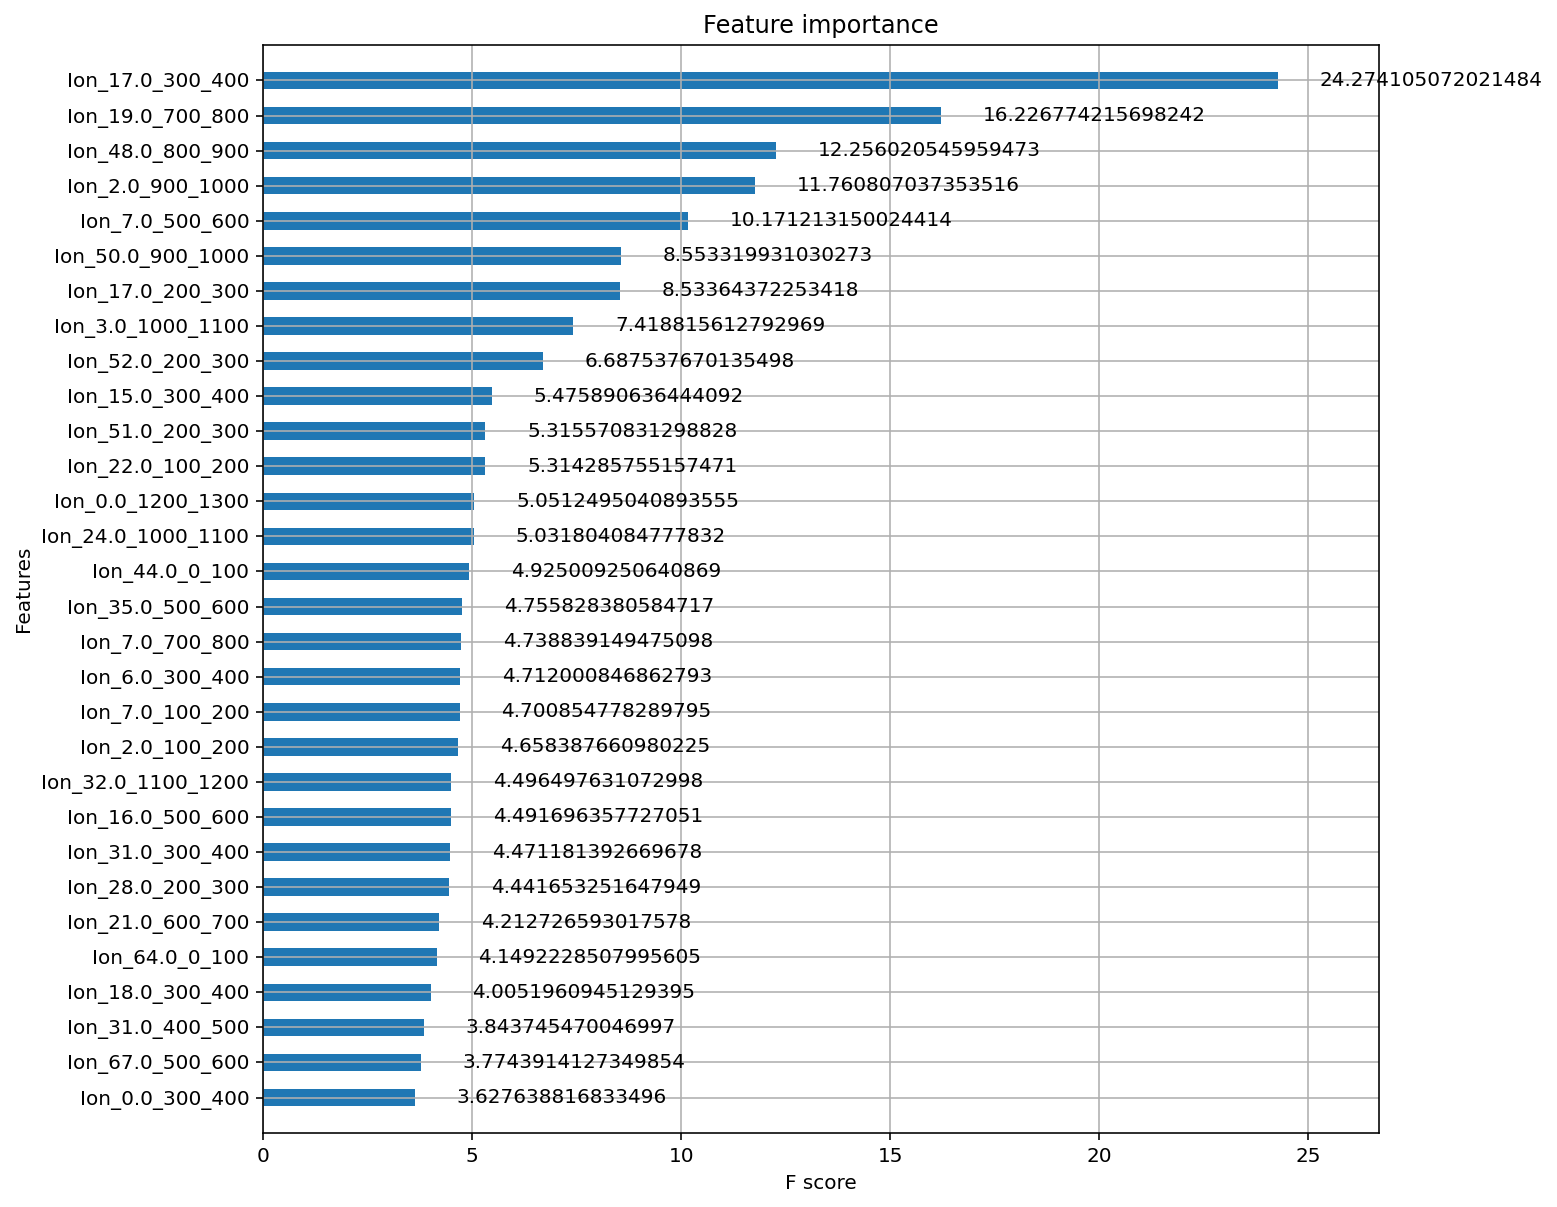

LABEL: carbonate


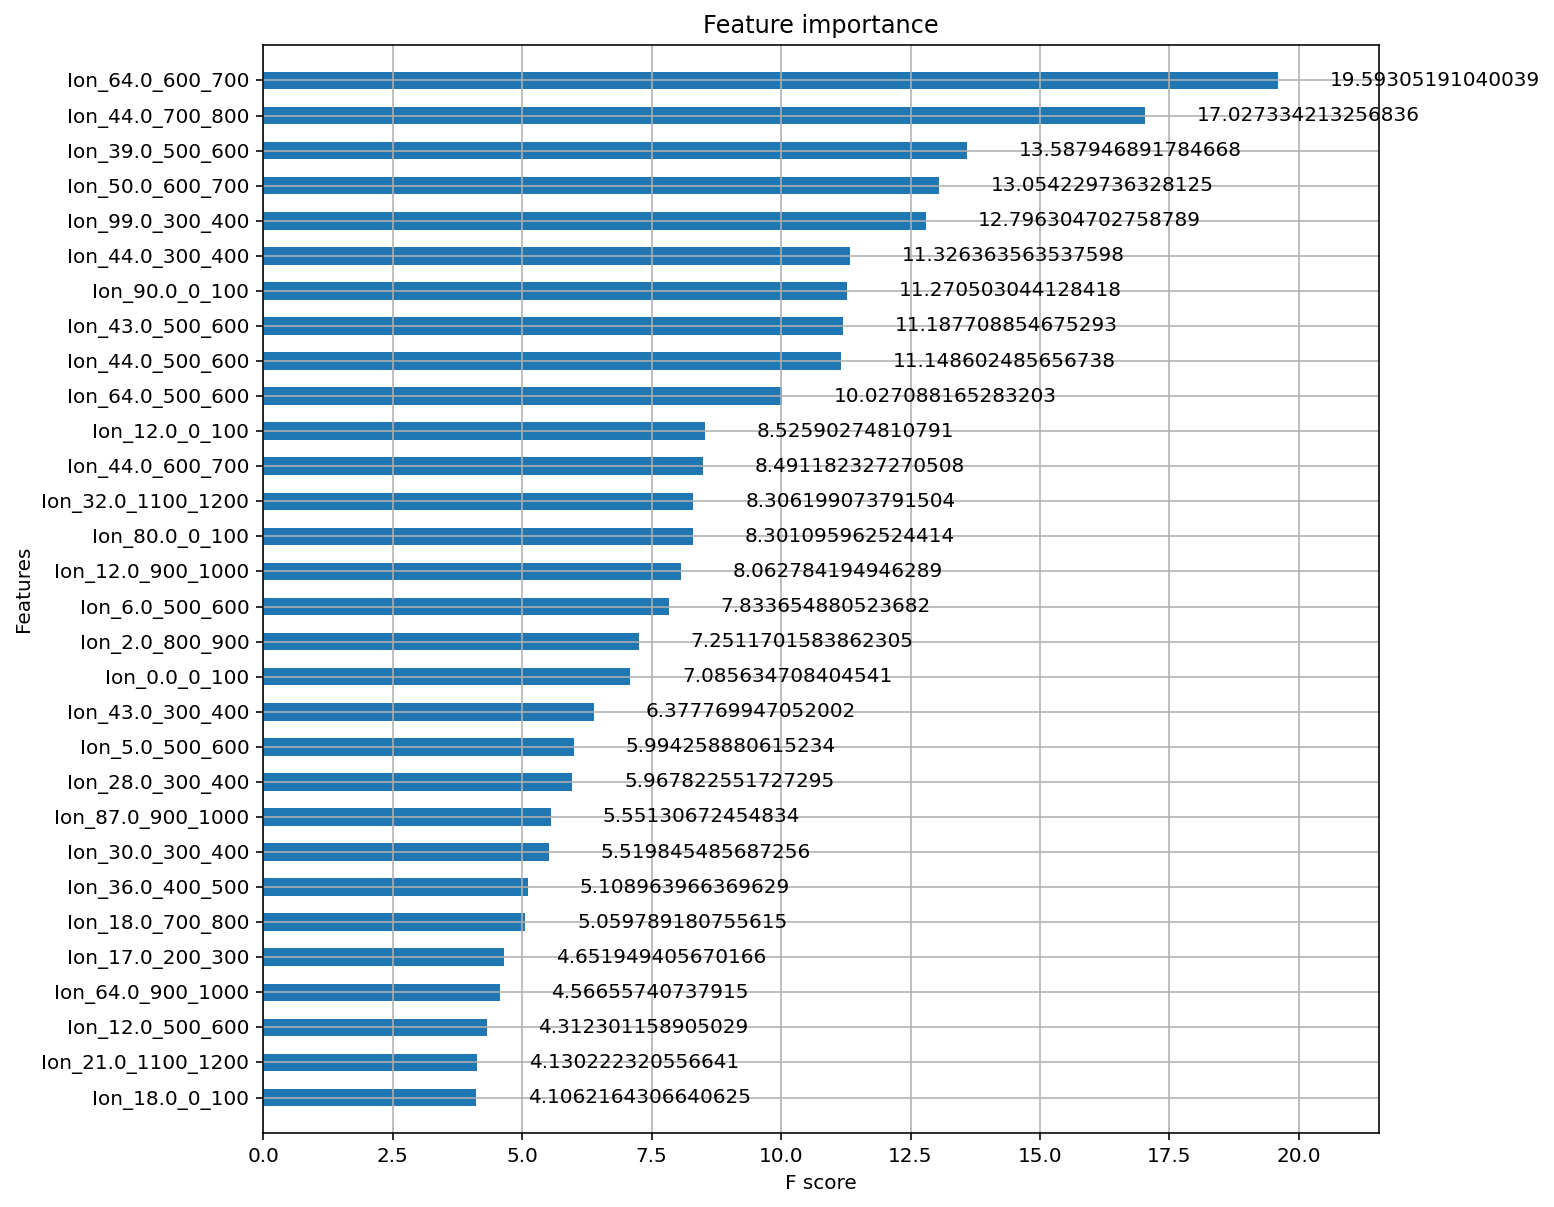

LABEL: chloride


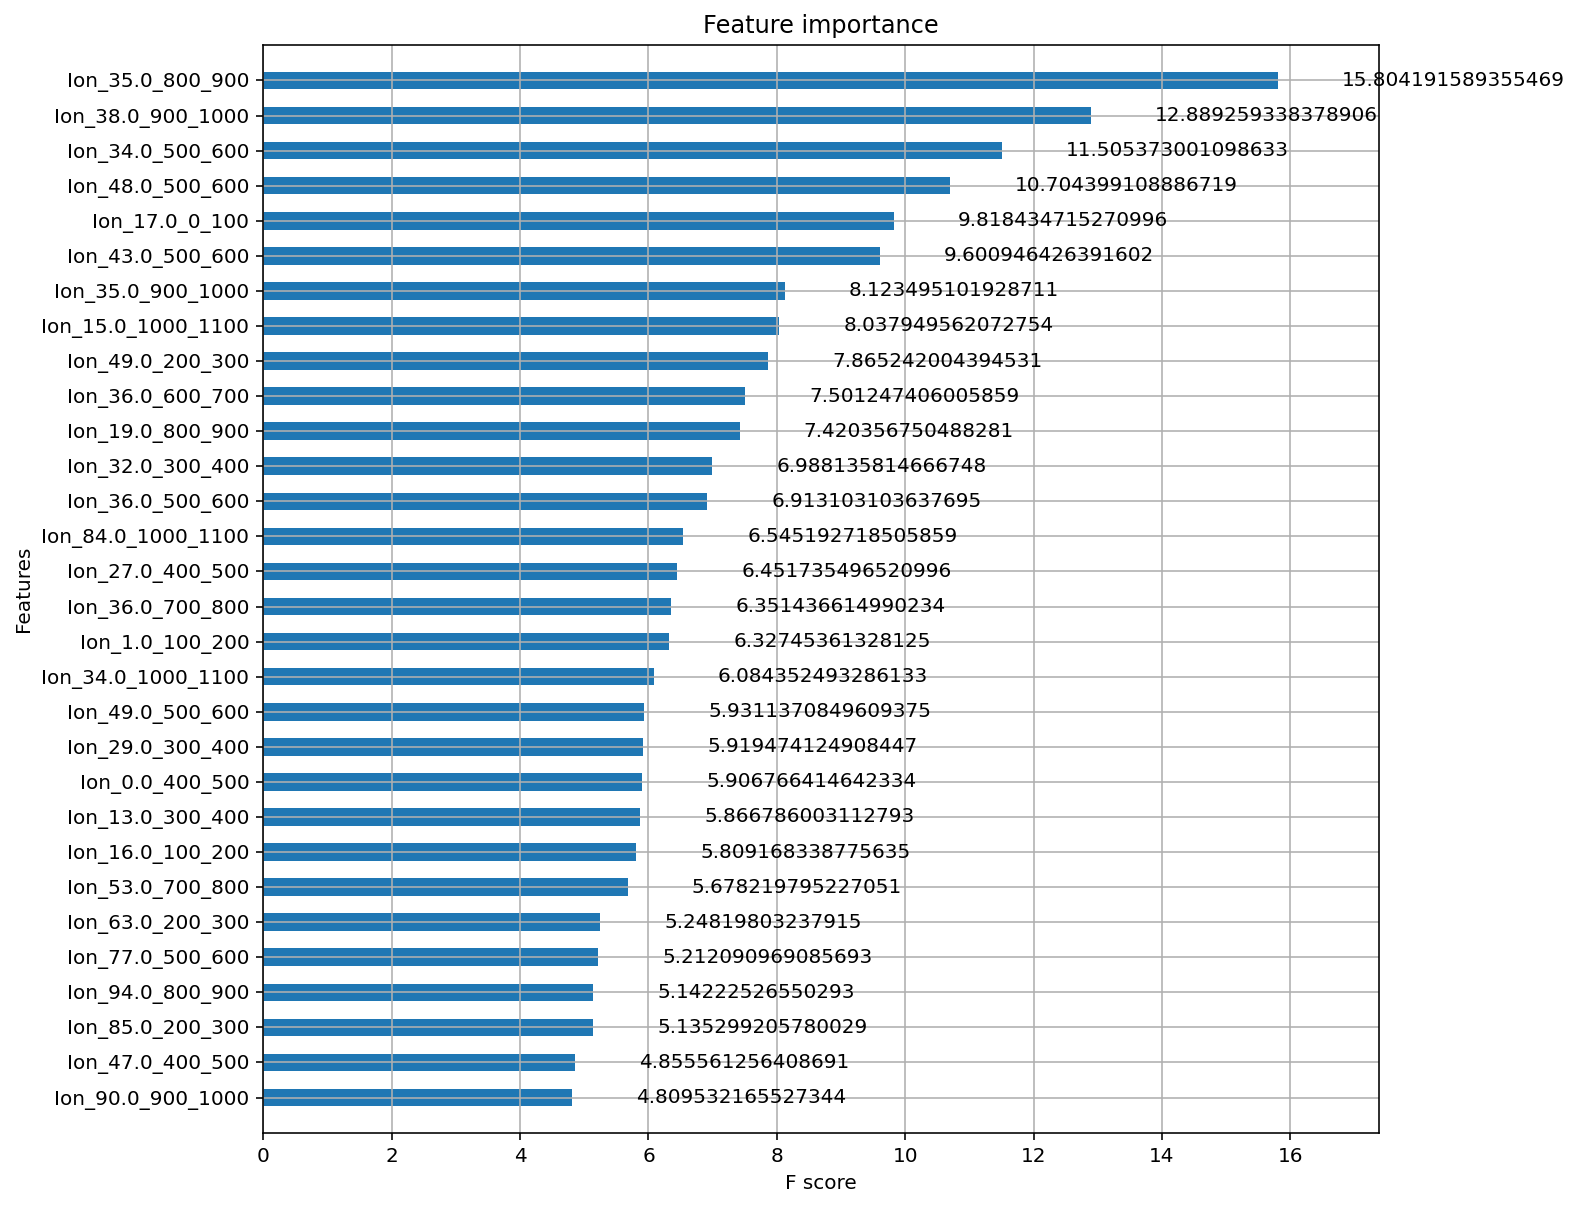

LABEL: iron_oxide


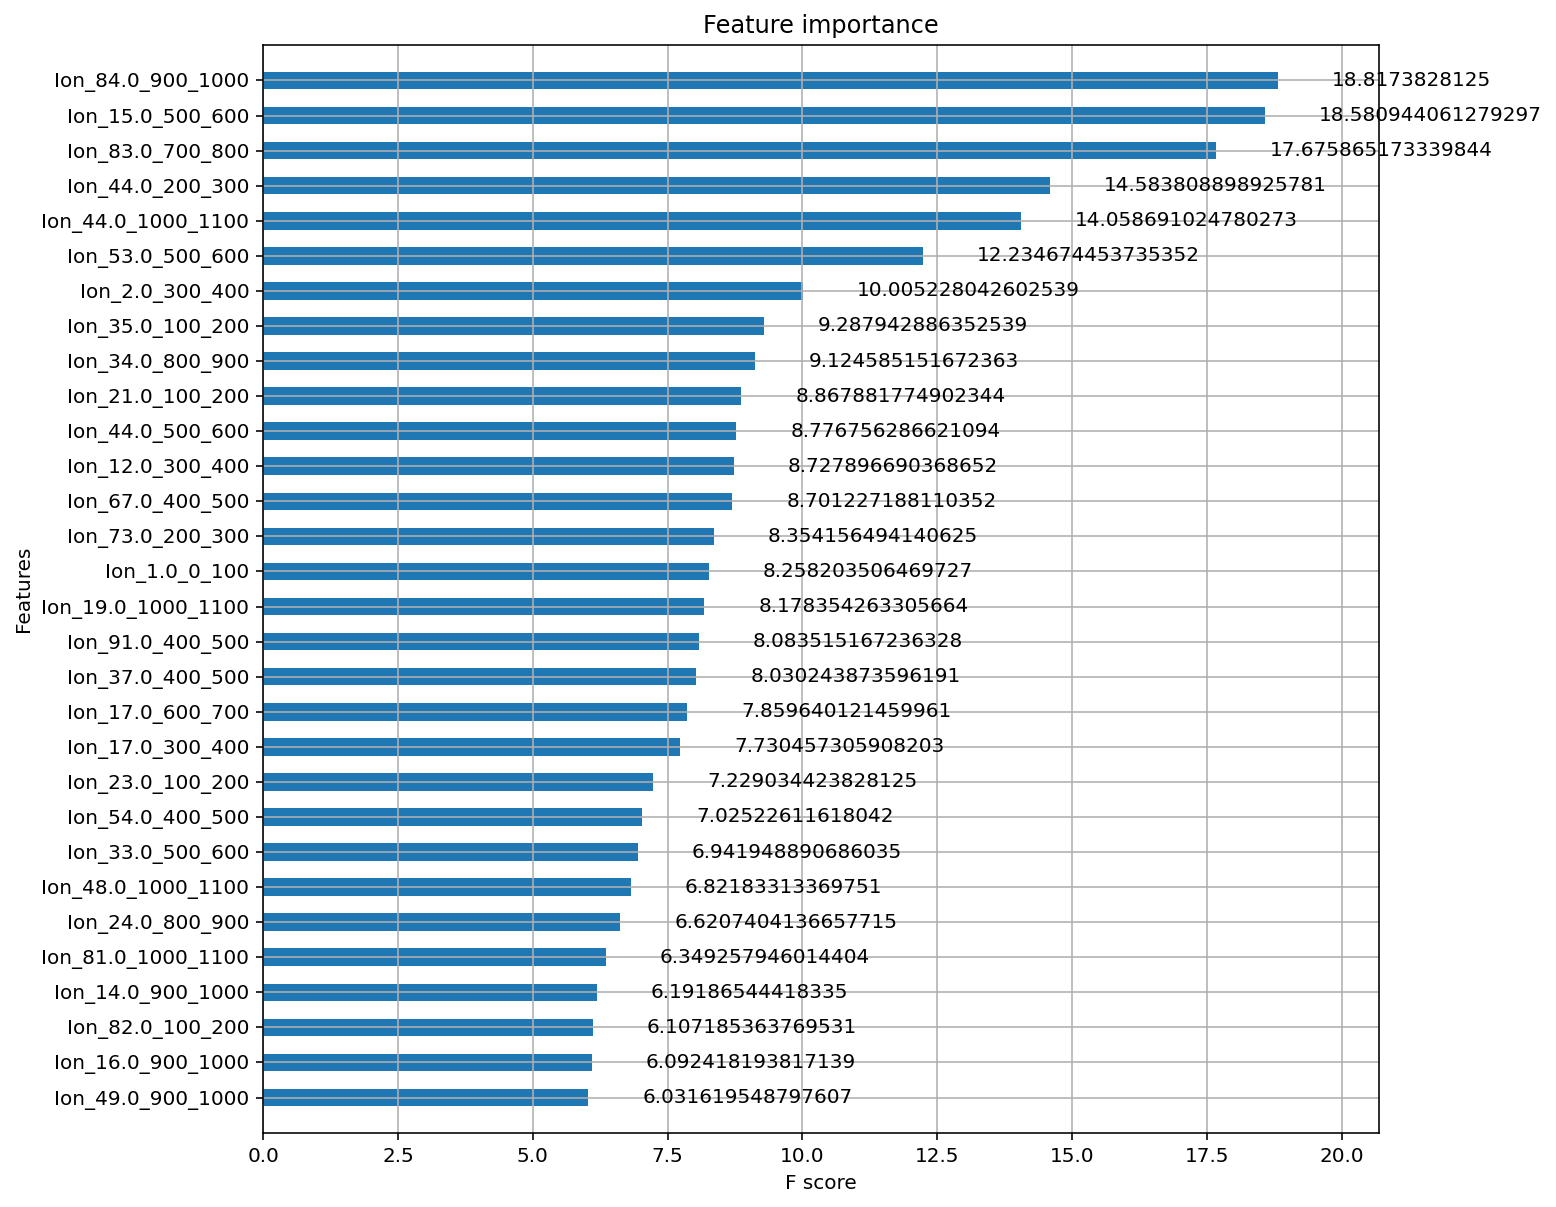

LABEL: oxalate


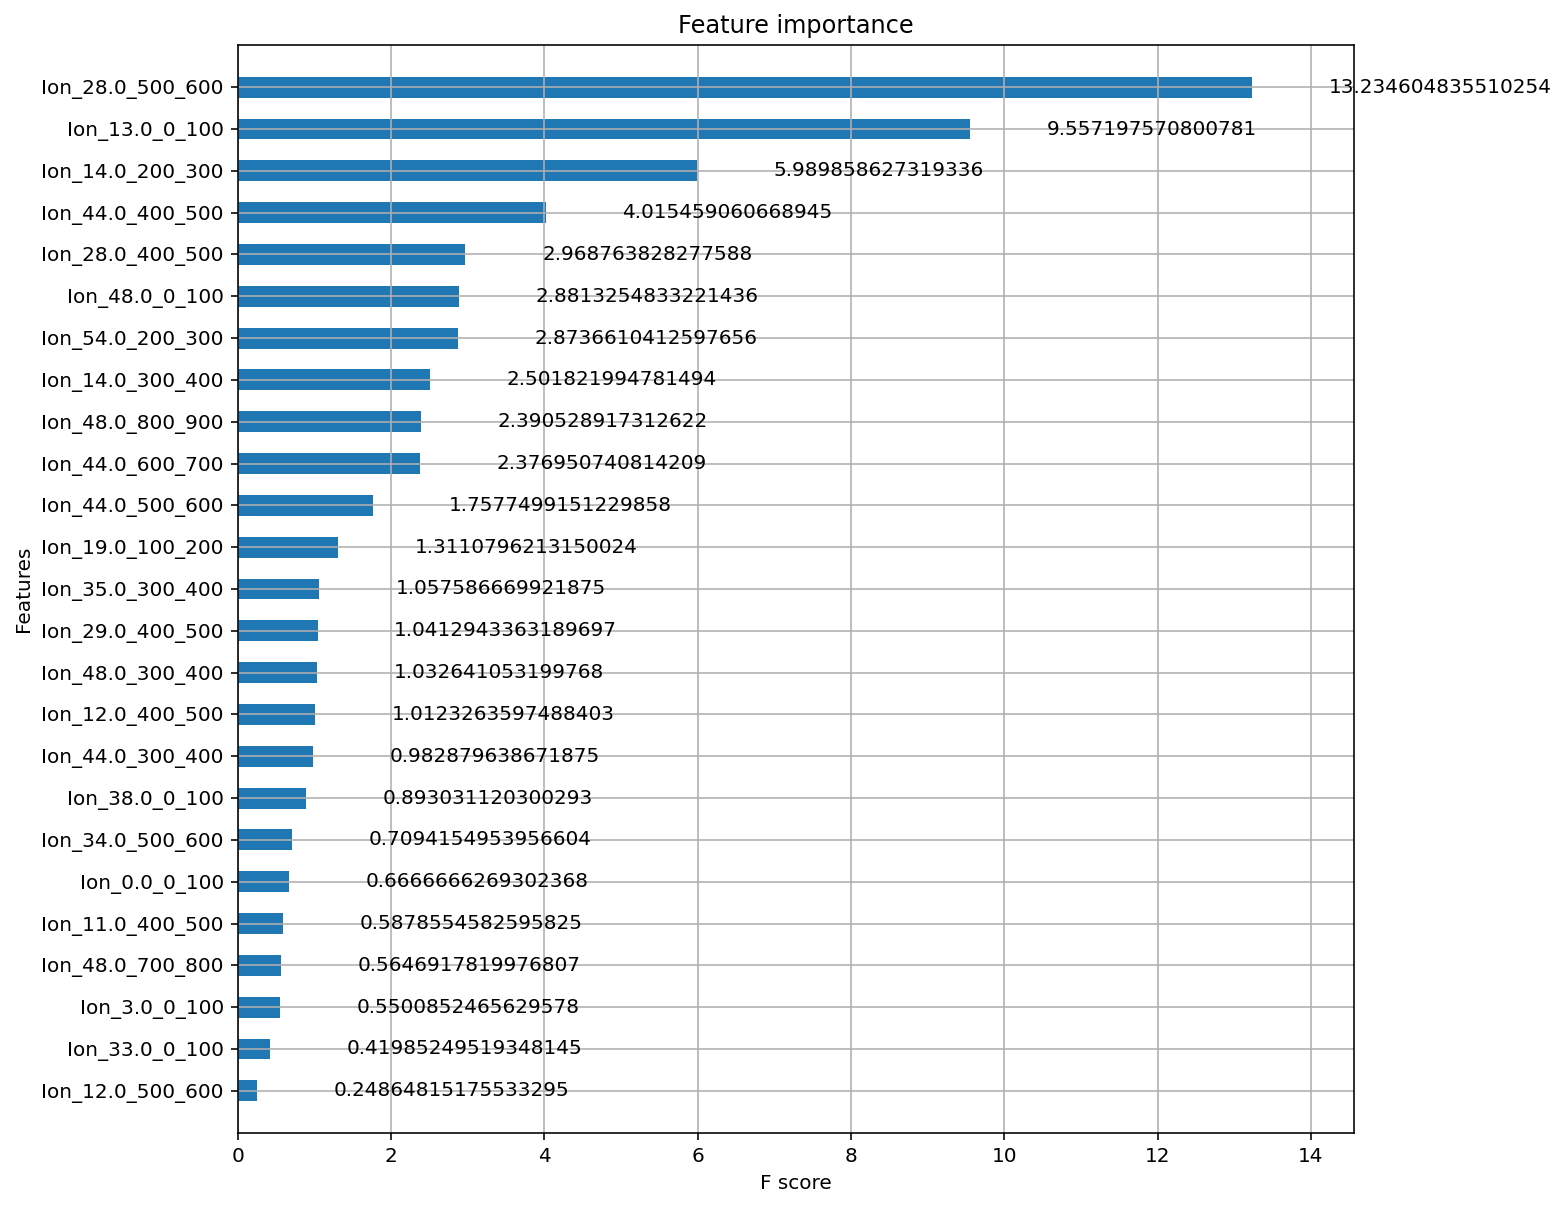

LABEL: oxychlorine


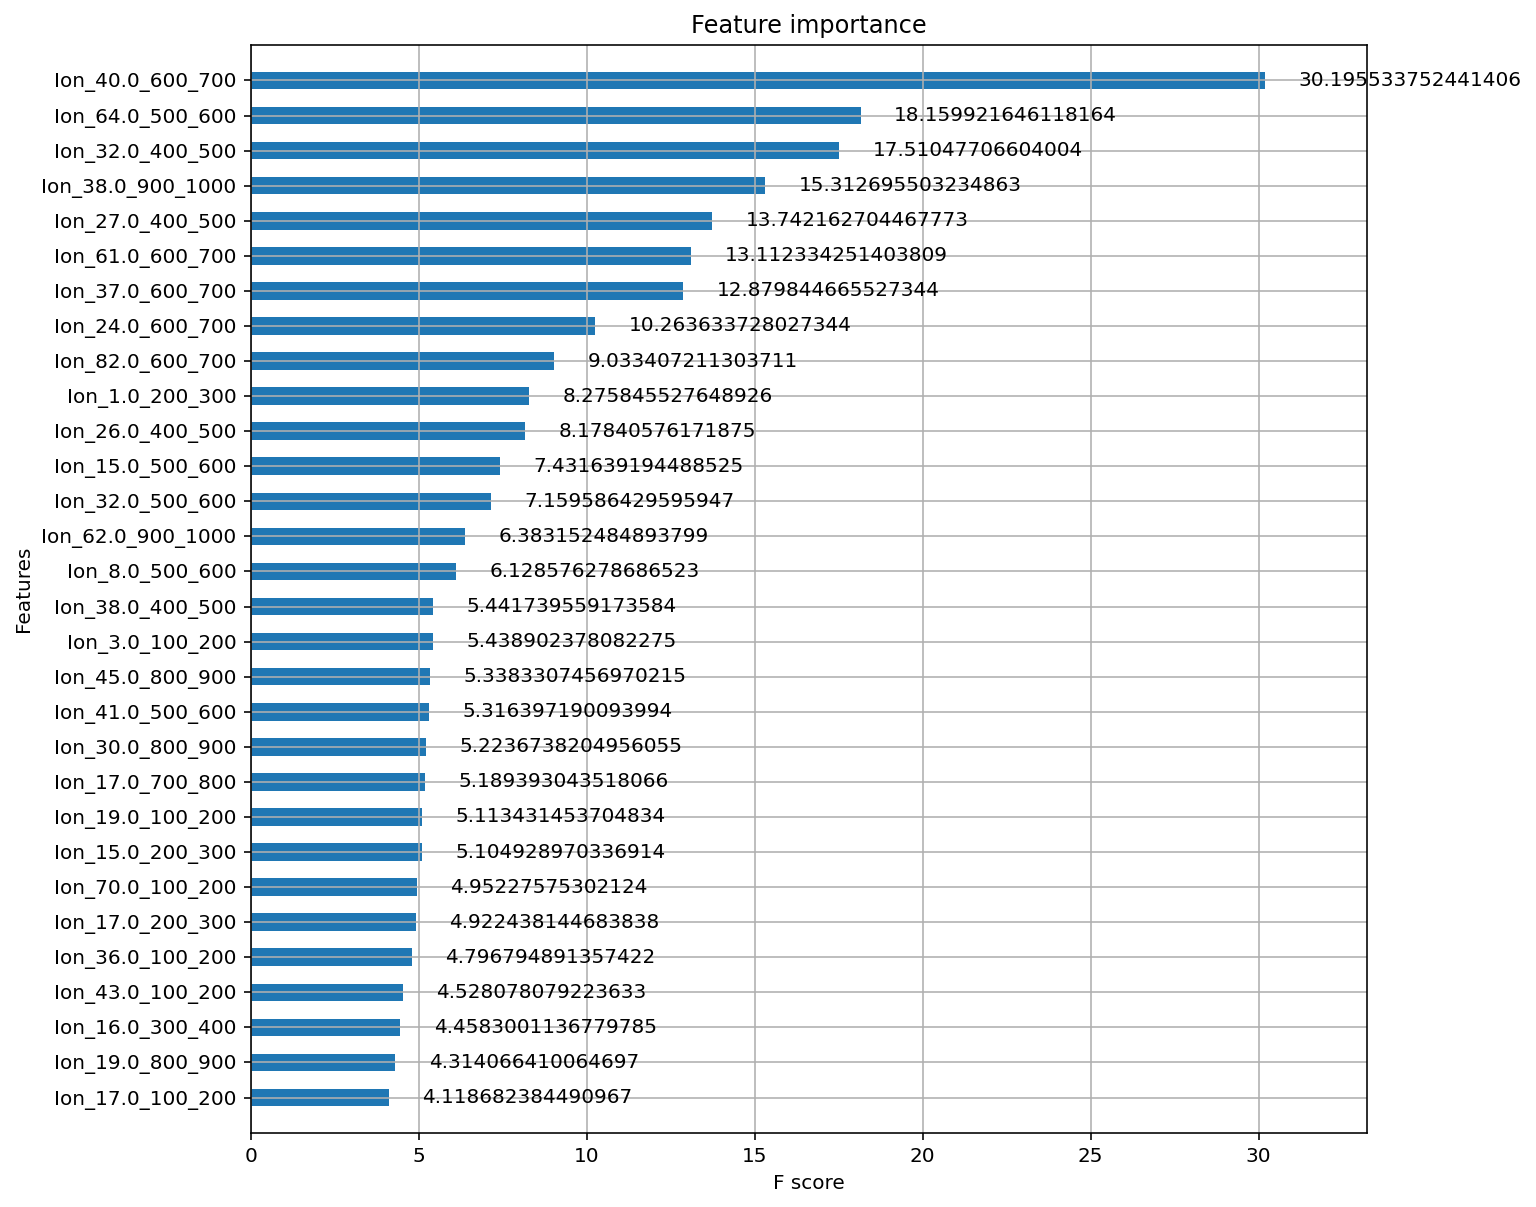

LABEL: phyllosilicate


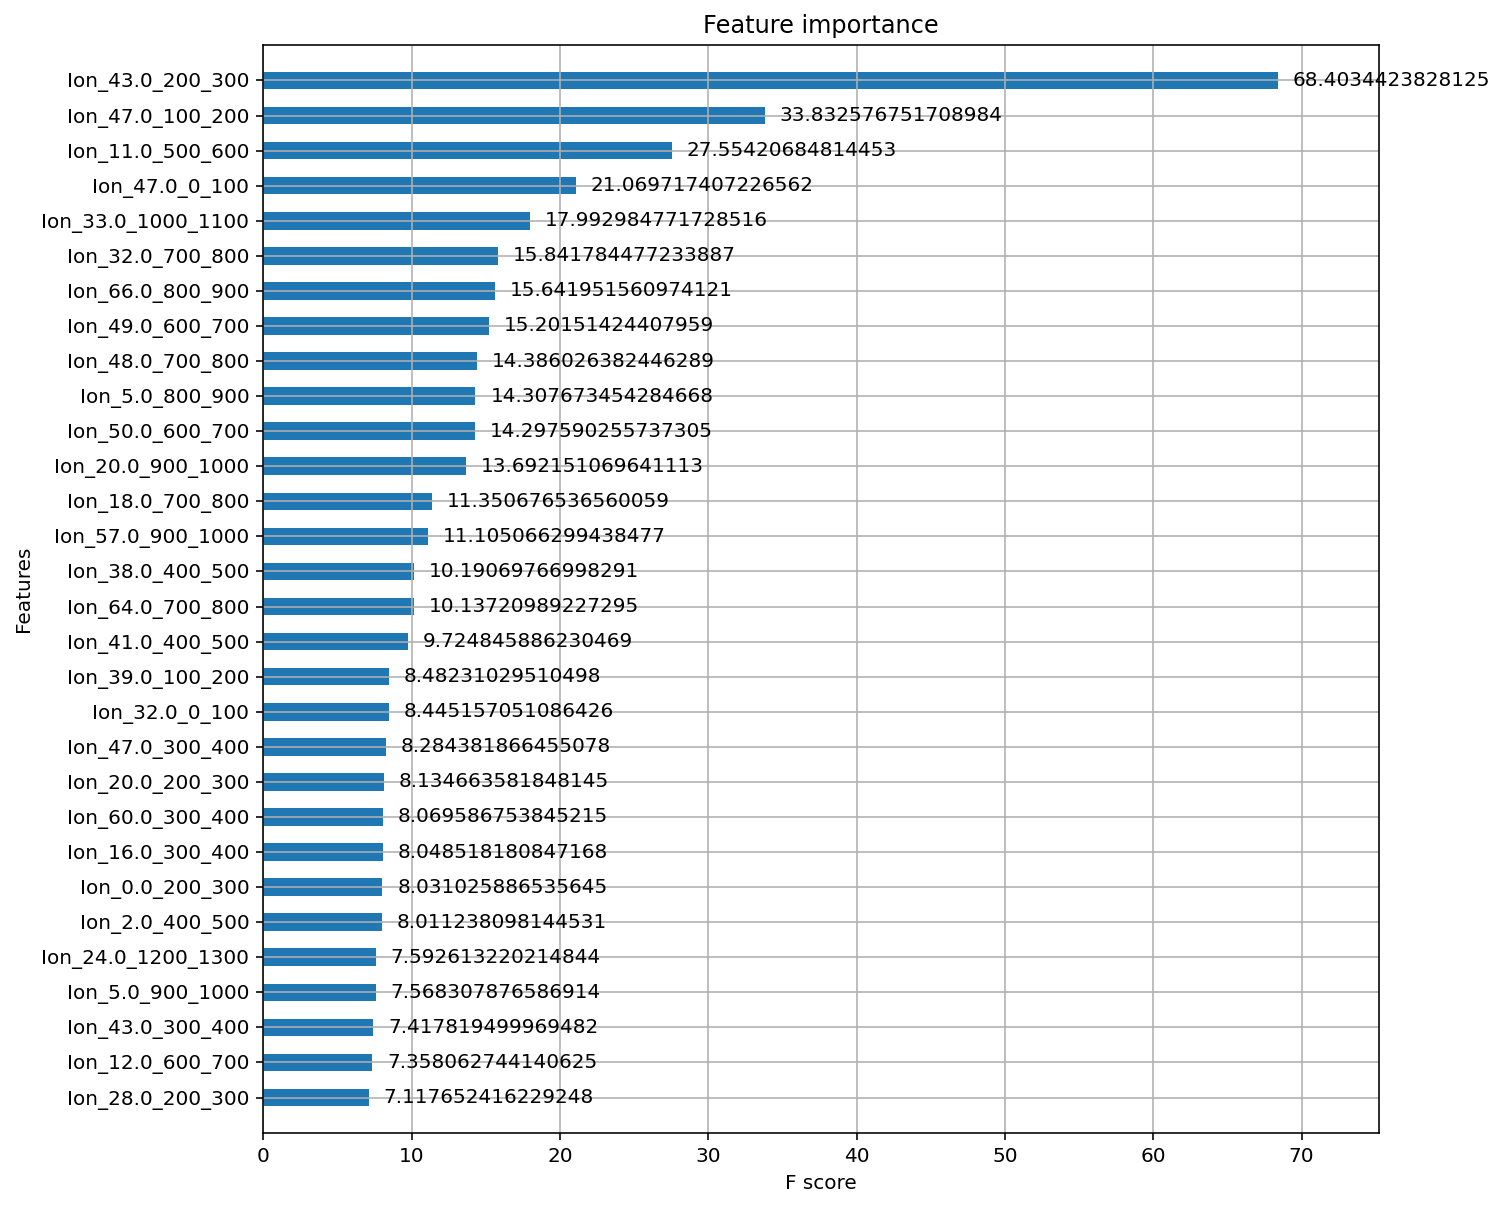

LABEL: silicate


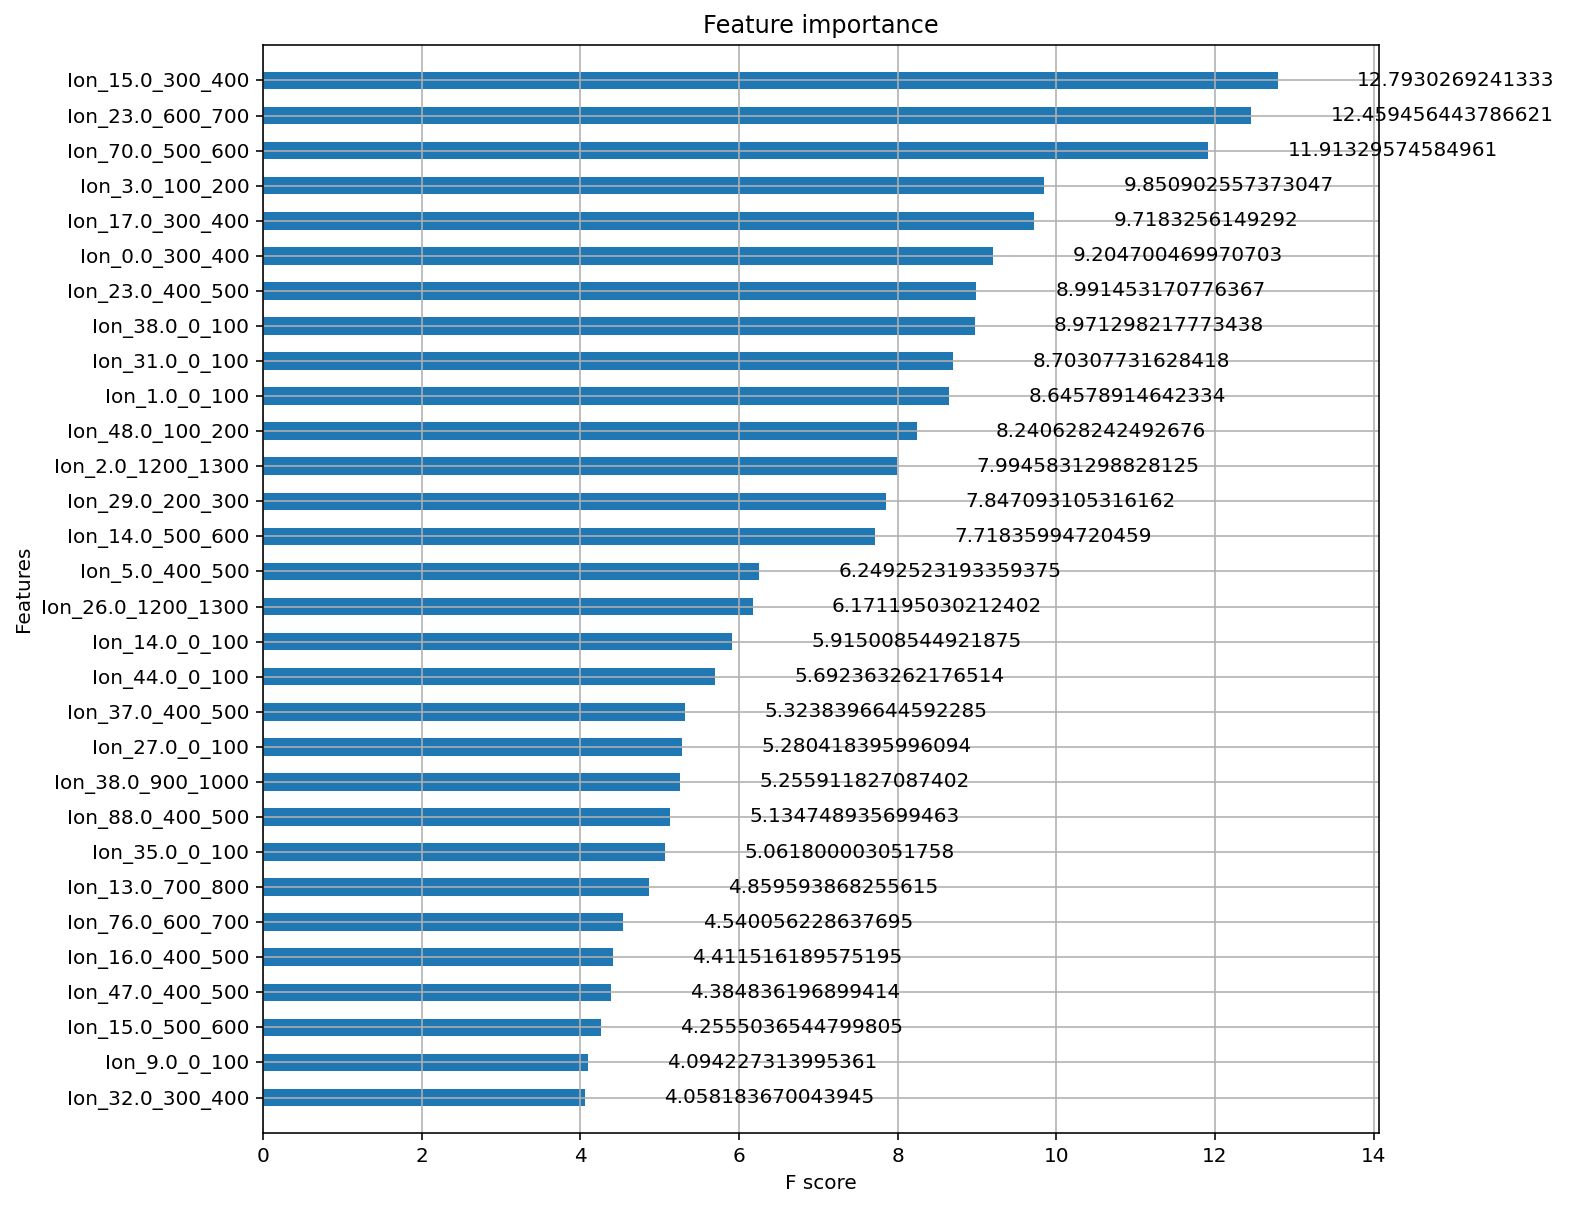

LABEL: sulfate


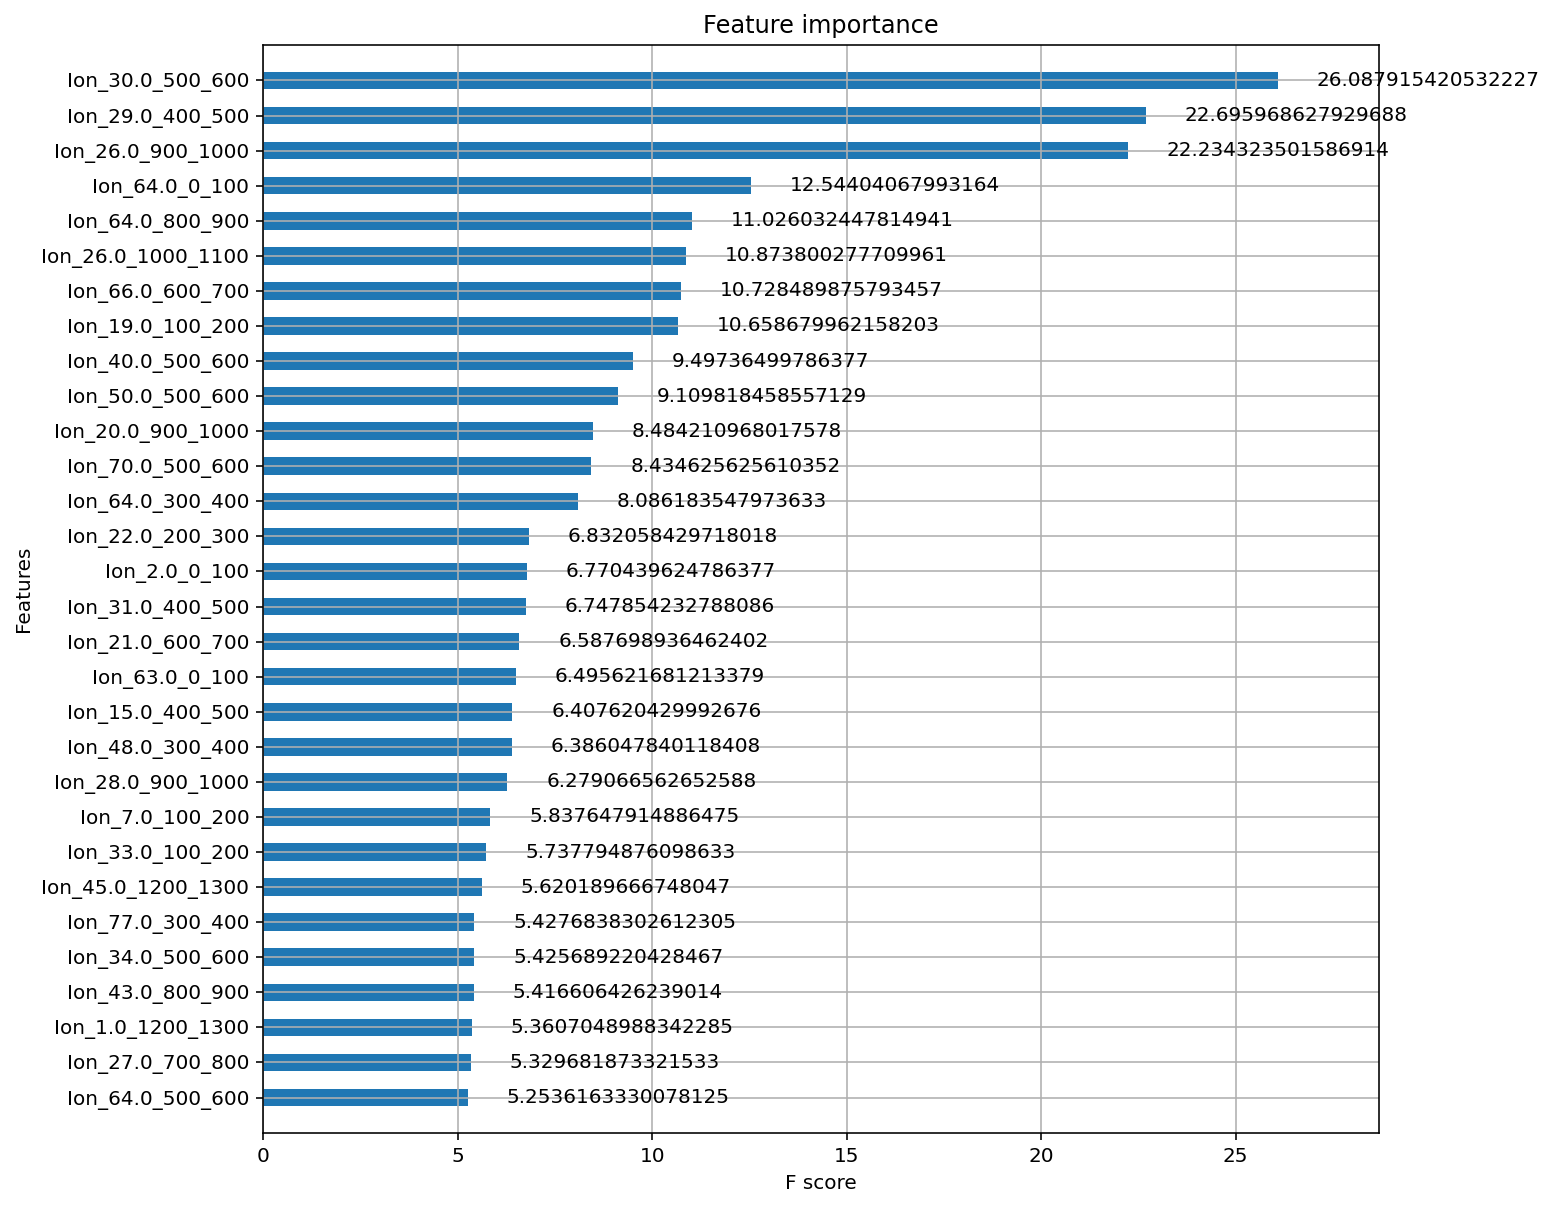

LABEL: sulfide


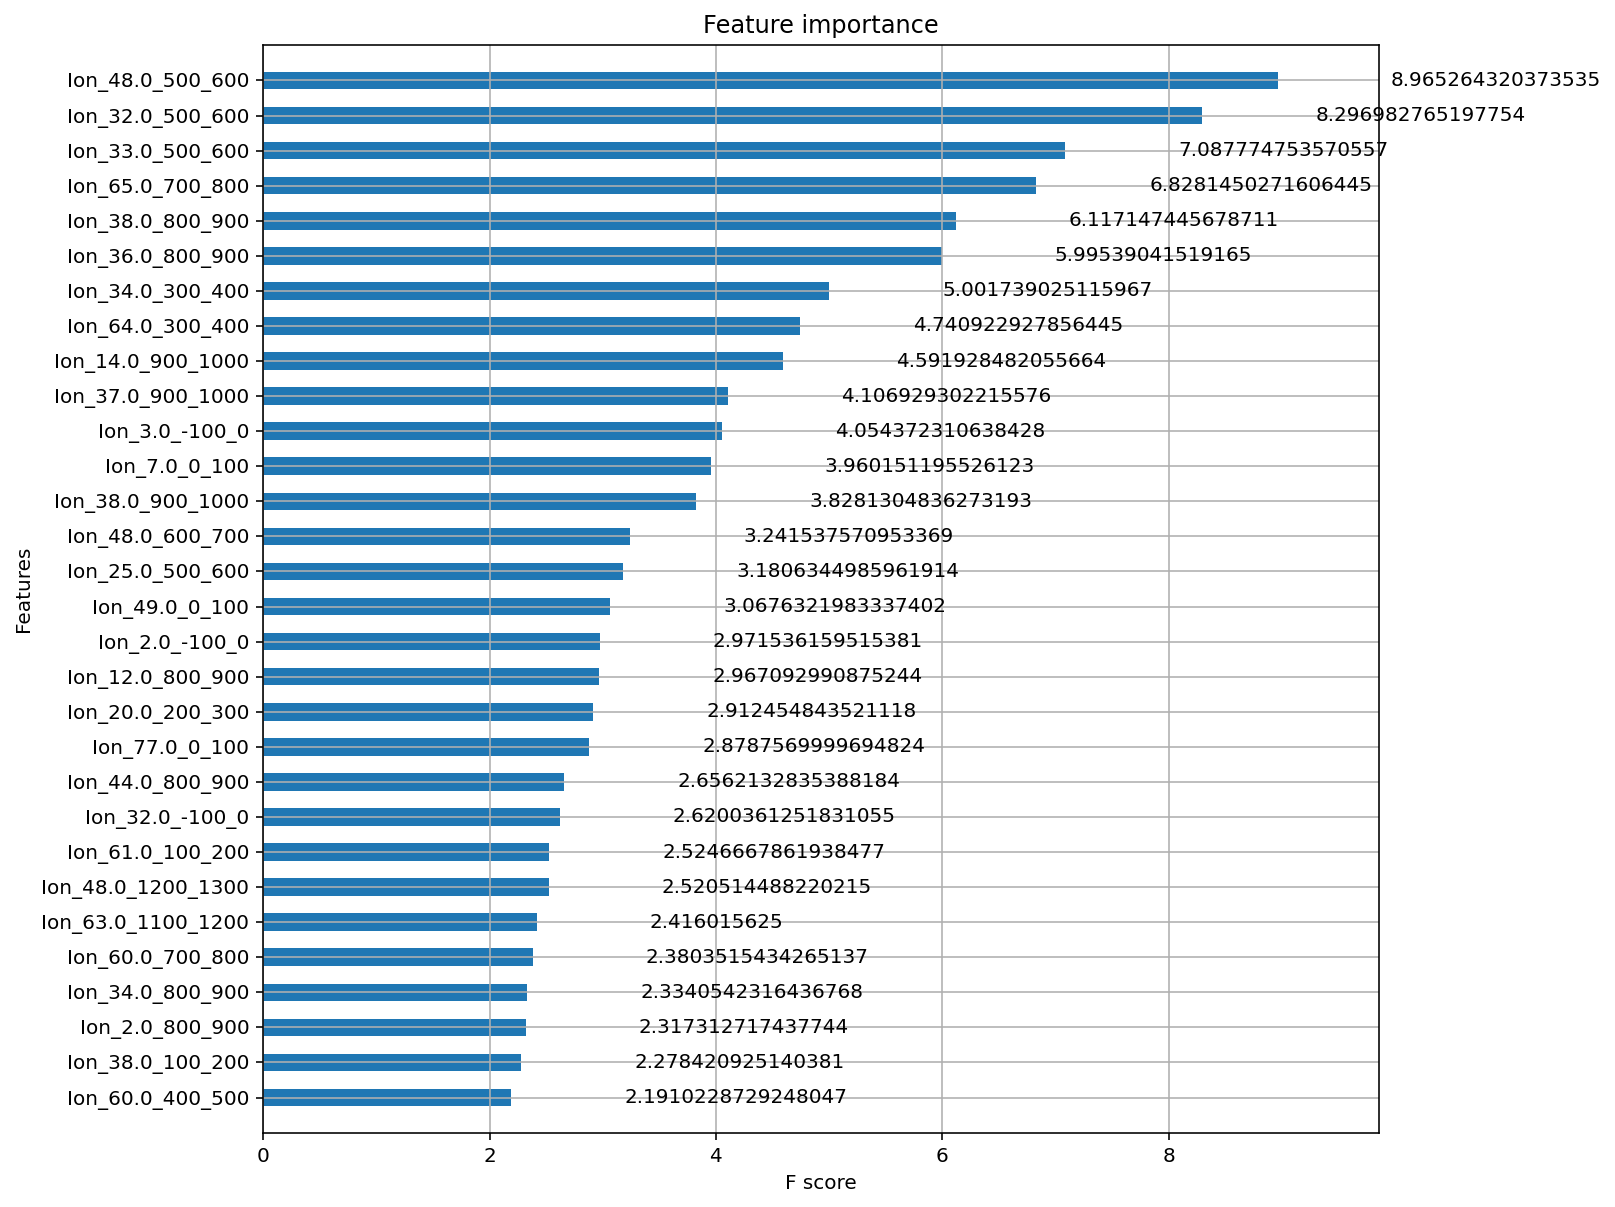


Average Log Loss: 0.1647
Log Loss per Label:
{'basalt': 0.1731241113563739, 'carbonate': 0.11170066900164832, 'chloride': 0.19042553430875236, 'iron_oxide': 0.21836558054587232, 'oxalate': 0.026719068769461517, 'oxychlorine': 0.17881238033441363, 'phyllosilicate': 0.25518642418626514, 'silicate': 0.22212086894367963, 'sulfate': 0.19530217146116768, 'sulfide': 0.0749714992948035}
(293, 10)


In [14]:
# ===== TRAIN =====
cvloss, submission_model = training.train_tbl(
    df_train=X_tr,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=X_vlte,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_tr',
    fts_select_cols=SFM_COLUMNS,
    )

# Compute validation loss when full model is trained
mloss, mloss_avg = training.compute_valid_loss(submission_model,
                                               valid_files, valid_labels,
                                               target_labels_list,
                                               sub_name=MODEL_NAME + '_tr',
                                               fts_select_cols=True)

In [17]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'VALID FM LogLoss: {mloss_avg}')
print(f'CV logLoss Label')
print(cvloss)

CV Logloss: 0.1646728308202438
VALID FM LogLoss: 0.1608679787746516
CV logLoss Label
{'basalt': 0.1731241113563739, 'carbonate': 0.11170066900164832, 'chloride': 0.19042553430875236, 'iron_oxide': 0.21836558054587232, 'oxalate': 0.026719068769461517, 'oxychlorine': 0.17881238033441363, 'phyllosilicate': 0.25518642418626514, 'silicate': 0.22212086894367963, 'sulfate': 0.19530217146116768, 'sulfide': 0.0749714992948035}


**TRAIN & VALID**

In [ ]:
_, SFM_COLUMNS = feature_selection.fts_select(
    target_labels_list, FTS_NAME, MODEL_NAME, 'trvl',
    X_tr, X_vlte, train_labels, valid_files, valid_labels
)

In [ ]:
# ===== TRAIN =====
cvloss, submission_model = training.train_tbl(
    df_train=X_trvl,
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test=X_vlte,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_trvl'
    )

In [ ]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'CV logLoss Label')
print(cvloss)

**SAM TRAINING**

In [ ]:
# ===== TRAIN SAM =====
cvloss, submission_model = training.train_tbl(
    df_train=X_tr_sam,
    df_labels=sam_labels,
    target_list=target_labels_list,
    df_test=X_vl_sam,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_sam',
    test_sam=True
    )

# Compute validation loss when full model is trained
mloss, mloss_avg = training.compute_valid_loss(submission_model,
                                               sam_files, sam_labels,
                                               target_labels_list,
                                               sub_name=MODEL_NAME + '_sam')

In [ ]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'VALID FM LogLoss: {mloss_avg}')
print(f'CV logLoss Label')
print(cvloss)